In [1]:
import datetime                  # test + Uncertainty
import pandas as pd              # test + Uncertainty
import numpy as np               # test + Uncertainty
import pickle5 as pickle                    # Uncertainty
from tqdm import tqdm

#import test_model as tm          # test
import test_uncertainty_Softmax_v2 as tuc   # Uncertainty
from humanfriendly import format_timespan

from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

from sklearn.metrics import roc_auc_score
import performance

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from scipy.special import entr

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [2]:
execute_test = False
start_date=datetime.datetime.now()
print(start_date)
if execute_test:        
    %run test_model --config ../config/config_squeezenet1_0.ini

2021-05-17 21:34:11.327057


## RUN TEST ON PICTURES

In [3]:
pd.set_option('max_colwidth', -1)
# idx=np.argmax(df_result_ensemble.iloc[0]['outputs_mean'])
# df_result_ensemble.iloc[0]['outputs_mean'][idx]

In [4]:
# tm1.df_result
print(f'uncertainty running: {datetime.datetime.now()}')

uncertainty running: 2021-05-17 21:34:11.337255


## RUN UNCERTAINTY CALCULATIONS

In [5]:
#pd.set_option('display.max_rows', 500)
# saving a DataFrame as csv saves lista (e.g. outputs_mean) as string which leads to conversion problems 
# while loading. so, it's better to save as a pickle file and load it back.
# with open('../results/squeezenet1_0_11.05.2021_02.07.07_df_result_ensemble.pkl', 'rb') as fp:
#      df_result_ensemble = pickle.load(fp)

# df_result_ensemble

In [6]:
# tuc1 = tuc.test_uncertainty('../config/config_squeezenet1_0.ini')
# tuc1 = tuc.test_uncertainty('../config/config_alexnet.ini')
# tuc1 = tuc.test_uncertainty('../config/config_resnet18.ini')
use_sample_weights = [0,1,3,5,6]
#use_sample_weights = [-1]  # if -1 then use all weights in the given csv file
tuc1 = tuc.test_uncertainty('../config/config_densenet121.ini', use_sample_weights)

2021-05-17 21:34:20,044  uncertainty   INFO  initializing uncertainty calculations


date and time = 17.05.2021_21.34.20


In [7]:
list(range(len(tuc1.df_result_ensemble.loc[0,'outputs_all'])))

[0, 1, 2, 3, 4]

In [8]:
index_to_class = pd.read_csv('../data/index_to_class.csv')
# index_to_class

In [9]:
class_to_index = index_to_class.set_index('class')
class_to_index.columns=['idx']
# class_to_index

## Accuracy Per Model

In [10]:
if use_sample_weights == [-1]:
    use_sample_weights = list(range(len(tuc1.df_result_ensemble.loc[0,'outputs_all'])))

# accuracy per model
for i, sample_model in enumerate(use_sample_weights):
    tuc1.df_result_ensemble[f'pred_{sample_model}'] = \
        tuc1.df_result_ensemble.loc[:,'outputs_all'].apply(lambda x: np.argmax(x[i]))

# accuracy per model
n_models = len(use_sample_weights)
count_correct = np.zeros(n_models)
lst_incorrect = [[] for i in range(n_models)]
    
for pic in range(len(tuc1.df_result_ensemble)):
    true_label = tuc1.df_result_ensemble['label'][pic]
    for i, sample_model in enumerate(use_sample_weights):
        if tuc1.index_to_class['class'][tuc1.df_result_ensemble[f'pred_{sample_model}'][pic]] == true_label:
            count_correct[i] += 1
        else:
            lst_incorrect[i].append(pic)

count_correct/len(tuc1.df_result_ensemble)*100

array([96.66205087, 96.81510094, 96.80052474, 96.76408425, 96.85154143])

In [11]:
m_count = np.zeros((n_models, n_models))
m_ratio = np.zeros((n_models, n_models))
m_jaccard = np.zeros((n_models, n_models))  # (A&B)/(A+B)
for m1 in range(n_models):    
    for m2 in range(m1+1,n_models):
        lst_diff=[]
        lst_same=[]
        for i in lst_incorrect[m1]:
            if i in lst_incorrect[m2]:
                lst_same.append(i)
            else:
                lst_diff.append(i)
                
        m_count[m1,m2]=len(lst_diff)
        m_ratio[m1,m2]=round((len(lst_diff)/len(lst_incorrect[m1])),2)
        total_incorrect = set(lst_incorrect[m1] + lst_incorrect[m2])
        m_jaccard[m1,m2]=round(len(lst_same)/len(total_incorrect),2)   

print('Diff_count matrix for incorrect labels between different models')
print(m_count)

print('\nDiff_ratio matrix for incorrect labels between different models')
print(m_ratio)

print('\nJaccard similarity matrix for incorrect labels between different models')
print(m_jaccard)

Diff_count matrix for incorrect labels between different models
[[ 0. 88. 74. 82. 92.]
 [ 0.  0. 66. 71. 73.]
 [ 0.  0.  0. 67. 67.]
 [ 0.  0.  0.  0. 70.]
 [ 0.  0.  0.  0.  0.]]

Diff_ratio matrix for incorrect labels between different models
[[0.   0.19 0.16 0.18 0.2 ]
 [0.   0.   0.15 0.16 0.17]
 [0.   0.   0.   0.15 0.15]
 [0.   0.   0.   0.   0.16]
 [0.   0.   0.   0.   0.  ]]

Jaccard similarity matrix for incorrect labels between different models
[[0.   0.7  0.75 0.71 0.7 ]
 [0.   0.   0.73 0.71 0.72]
 [0.   0.   0.   0.73 0.75]
 [0.   0.   0.   0.   0.75]
 [0.   0.   0.   0.   0.  ]]


In [12]:
# for i in range(len(tuc1.df_result_ensemble)):
#     tuc1.df_result_ensemble['outputs_all'][i] = tuc1.df_result_ensemble['outputs_all'][i][lst_max5]

In [13]:
tuc1.run()
df_final = tuc1.df_uncertainty
df_final_summary = tuc1.df_final_summary

df_results_eval=df_final
#df_results_eval.loc[:0,:]

2021-05-17 21:34:21,501  uncertainty   INFO  Evaluating top-2 related uncertainty
/Users/melih/Documents/Masters/KTH_DASE-ICT Innovation_Data Science/___Master Thesis/PyTorch_Exercise/arkusai/code/test_uncertainty_Softmax_v2.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_ensemble['outputs_all'][i] = output
2021-05-17 21:34:33,748  uncertainty   INFO  Accuracy: 96.9827 ... correct_predictions: 13307 ... all_pictures: 13721
2021-05-17 21:34:33,749  uncertainty   INFO  Out of 414 incorrect predictions, 128 of them were having the 2nd best predictions as the ground truth: 30.9179%


In [14]:
'''
After picking the best-5 accuracy-models, the ensemble accuracy dropped to 96.9827 from 97.092
BUT
CERTAINTY results getting BETTER
'''
# lst_acc = count_correct/len(tuc1.df_result_ensemble)*100
# lst_acc_sort = lst_acc.copy()
# lst_acc_sort.sort()
# lst_acc_sort[2]
# lst_max5 = [i for i in range(len(lst_acc)) if lst_acc[i]>=lst_acc_sort[2]]
# lst_max5

'\nAfter picking the best-5 accuracy-models, the ensemble accuracy dropped to 96.9827 from 97.092\nBUT\nCERTAINTY results getting BETTER\n'

In [15]:
tuc1.df_result_ensemble

picture        model label  \
0      MA160814197500042.017-K_9_0_.png   densenet121  9      
1      MA160814197500041.070-K_4_0_.png   densenet121  4      
2      MA160873676300027.057-K_20_1_.png  densenet121  20     
3      MA1867826.007-K_22_0_.png          densenet121  22     
4      MA1867835.121-K_7_1_.png           densenet121  7      
...                         ...                   ... ..      
13716  MA160814197500040.007-K_22_0_.png  densenet121  22     
13717  MA160865191500027.025-K_6_1_.png   densenet121  6      
13718  MA160873676300051.029-K_5_1_.png   densenet121  5      
13719  MA160873676300019.014-K_13_1_.png  densenet121  13     
13720  MA1867826.091-K_5_0_.png           densenet121  5      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              outputs_all  \
0      [[1.3777607e-11, 7.888546e-09, 9.359774e-12, 8.951373e-11, 2.9096934e-09, 3.553561e-11, 1.5959344e-10, 1.4422702e-06, 0.9999981, 2.8157159e-09, 4.1717826e-10, 2.0935842e-09, 1.4377367e-10, 5.3141402e-09, 6.29545e-10, 2.2031068e-09, 6.510161e-10, 5.959406e-12, 1.269169e-13, 2.2520248e-09, 4.40118e-11, 5.381242e-10, 1.6819388e-11, 1.5694416e-11], [1.0604451e-12, 5.9858216e-09, 2.4576704e-11, 1.0788693e-09, 3.7888567e-10, 2.5812785e-10, 8.034414e-12, 2.9794933e-07, 1.0, 7.9421214e-10, 3.0566155e-10, 8.053693e-10, 9.191709e-11, 1.6368384e-09, 6.802913e-11, 1.9769286e-09, 5.47986e-09, 1.5104224e-12, 2.0771132e-13, 9.588528e-10, 8.243136e-11, 5.5732034e-11, 1.4141129e-11, 1.702722e-12], [7.9143386e-11, 2.3094936e-08, 2.3794767e-11, 1.0118796e-09, 8.605439e-09, 5.769971e-10, 3.530498e-10, 9.3661026e-07, 1.0, 2.7318626e-08, 2.5683098e-09, 1.7851413e-09, 1.0797361e-09, 1.2924677e-08, 2.0573819e-10, 2.1678105e-08, 9.624849e-09, 2.2859253e-11, 6.531456e-13, 1.5837541e-09, 3.929004e-10, 9.189996e-10, 2.350227e-10, 9.5870005e-12], [9.207655e-12, 3.2183727e-09, 2.541486e-11, 3.6778725e-10, 4.0060937e-09, 9.5784145e-11, 5.6125667e-11, 8.675717e-08, 1.0, 1.3372181e-09, 3.0855683e-11, 3.1267028e-10, 1.0083932e-11, 3.6562269e-09, 4.393556e-11, 4.1369597e-09, 5.930328e-10, 2.1760788e-12, 2.205074e-13, 4.1167442e-10, 7.206555e-11, 1.2331766e-10, 2.4383493e-11, 1.2315629e-12], [1.4649147e-09, 8.425783e-07, 2.5629096e-11, 2.5910627e-08, 2.2291966e-08, 9.591454e-10, 5.8281063e-10, 4.5455076e-07

In [16]:
end_date = datetime.datetime.now()
t_delta = end_date - start_date

print(f'ALL done: {end_date} .. total calculation time: {format_timespan(t_delta.seconds)}')

ALL done: 2021-05-17 21:34:33.790612 .. total calculation time: 22 seconds


In [17]:
tuc1.df_combine

count_all  count_match  count_unmatch  accuracy  mean_all  \
actual_class                                                              
1             598        589          9              0.9849    0.014246   
10            578        564          14             0.9758    0.020803   
11            593        577          16             0.9730    0.021291   
12            585        576          9              0.9846    0.016735   
13            648        619          29             0.9552    0.098268   
14            627        574          53             0.9155    0.078301   
15            609        571          38             0.9376    0.059877   
16            579        571          8              0.9862    0.016327   
17            582        571          11             0.9811    0.022014   
18            588        576          12             0.9796    0.020577   
19            585        572          13             0.9778    0.027532   
2             600        587          13             0.9783    0.020889   
20            579        562          17             0.9706    0.027160   
21            637        591          46             0.9278    0.077760   
22            605        573          32             0.9471    0.053952   
3             595        587          8              0.9866    0.015347   
4             592        580          12             0.9797    0.019976   
5             591        584          7              0.9882    0.014375   
6             601        591          10             0.9834    0.015063   
7             584        575          9              0.9846    0.013236   
8             591        569          22             0.9628    0.027929   
9             583        567          16             0.9726    0.020199   
x             440        434          6              0.9864    0.017458   
y             151        147          4              0.9735    0.073458   

              entropy_all  u_entropy_all  mean_match  entropy_match  \
actual_class                                                          
1             0.068165     0.014867       0.004933    0.029751        
10            0.100869     0.022000       0.009160    0.049776        
11            0.112117     0.024453       0.006189    0.046729        
12            0.077072     0.016810       0.006257    0.032893        
13            0.457718     0.099830       0.066147    0.329830        
14            0.358450     0.078180       0.018997    0.098954        
15            0.273070     0.059558       0.012630    0.078284        
16            0.082351     0.017961       0.011003    0.057143        
17            0.123498     0.026935       0.010405    0.071611        
18            0.098376     0.021456       0.006178    0.037157        
19            0.133343     0.029083       0.013641    0.071324        
2             0.117535     0.025635       0.009298    0.062792        
20            0.134295     0.029290       0.013030    0.076928        
21            0.370020     0.080703       0.032297    0.170179        
22            0.264586     0.057707       0.019991    0.114089        
3             0.069199     0.015093       0.007764    0.037436        
4             0.104630     0.022820       0.010335    0.053528        
5             0.073752     0.016086       0.008011    0.043569        
6             0.077364     0.016873       0.007233    0.041089        
7             0.073627     0.016058       0.004670    0.029800        
8             0.124311     0.027113       0.007139    0.047138        
9             0.096668     0.021084       0.004107    0.030387        
x             0.088589     0.019322       0.012729    0.057110        
y             0.358914     0.078281       0.061471    0.303618        

              u_entropy_match  mean_unmatch  entropy_unmatch  \
actual_class                                                   
1             0.006489         0.623733      2.582150          
10            0.010856  

In [18]:
df_results_eval.columns

Index(['uncertainty', 'actual_class', 'best_pred', 'best_2nd_pred',
       'best_score', 'best_2nd_score', 'class_idx', 'best_index',
       'best_2nd_index', 'entr', 'u_entr', 'picture', 'model', 'P_jsd',
       'P_info', 'jsd', 'sum_H', 'H_sum', 'Mean', 'std', 'var', 'Certainty'],
      dtype='object')

In [65]:
def plot_metrics(plt, title='Softmax Score', metric_name='best_score',step_size=0.01, higher_better=True, is_norm=False):
    plus_minus = 5
    max_val = round(max(df_results_eval[metric_name]), 6)
    min_val = round(min(df_results_eval[metric_name]), 6)
    mean_val = round(np.mean(df_results_eval[metric_name]), 6)
    var_val = round(np.var(df_results_eval[metric_name]), 6)
    
    norm_name = f'{metric_name}_Norm'
    if is_norm and norm_name not in df_results_eval.columns:
        df_results_eval[norm_name]=df_results_eval[metric_name].apply(lambda x: (x-min_score)/
                                                                      (max_score-min_score)*100)
    
    print(f'max: {max_val} .. min: {min_val} .. mean: {mean_val} .. var: {var_val}')
    
    x=[]; y_match=[]; y_unmatch=[]
    for val in tqdm(np.arange(0, max_val + step_size, step_size)):
        x.append(val)
        len_match = len(df_results_eval[df_results_eval['actual_class'] == df_results_eval['best_pred']])
        len_unmatch = len(df_results_eval[df_results_eval['actual_class'] != df_results_eval['best_pred']])

        if higher_better:
            # FDR (False Discovery Rate) = FP/(FP+TP)  ... FDR = 1 - precision=1-PPV
            y_match.append(len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] <= val)])/len_match)
            # NPV (Negative Predictive Value) = TN/(TN+FN)
            y_unmatch.append(len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] <= val)])/len_unmatch)
        else:
            y_match.append(len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] >= val)])/len_match)
            y_unmatch.append(len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] >= val)])/len_unmatch)
            
    arr_diff=np.array(y_unmatch)-np.array(y_match)

    # find the threshold giving the max diff between MATCH (correct-predictions) 
    #                                          and UNMATCH (incorrect predictions)
    argmax = np.argmax(arr_diff)
    best_threshold = round(x[argmax], 2)

    lst_threshold = x[argmax-plus_minus:argmax+plus_minus]
    lst_unmatch = y_unmatch[argmax-plus_minus:argmax+plus_minus]
    lst_match = y_match[argmax-plus_minus:argmax+plus_minus]
    lst_diff = list(arr_diff[argmax-plus_minus:argmax+plus_minus])

    df_threshold = pd.DataFrame({'threshold': lst_threshold, 'unmatch': lst_unmatch, 
                                 'match': lst_match, 'diff': lst_diff})

    FN = round(y_match[argmax]*100,2)
    TP = 100 - FN
    TN = round(y_unmatch[argmax]*100,2)
    FP = 100 - TN
    print(f'\nWhen threshold={best_threshold}:')
    print(f'..... {FN}% of correctly classified images are below the threshold (FN)')
    print(f'while {TN}% of incorrectly classified images are below the threshold (TN)')
    print(f'TP: {TP}% .. TP: {FP}% .. TN: {TN}% .. FN: {FN}%')
    print(f'precision: {round(TP/(TP+FP), 2)}')
    print(f'recall: {round(TP/(TP+FN), 2)}')

    plt.plot(x, y_match)
    plt.plot(x, y_unmatch)
    th_best = np.zeros(len(x))
    th_best.fill(x[argmax])
    th_best = list(th_best)
    plt.plot(th_best, y_unmatch)

    plt.legend(['y_match', 'y_unmatch', 'th_best'])
#     plt.xlabel('Threshold')
#     plt.ylabel('% of Images')
    plt.set_xlabel('Threshold')
    plt.set_ylabel('% of Images')
    #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#     plt.title(title)
    plt.set_title(title)

    # plt.annotate('best threshold', 
    #              xy=(lst_threshold[argmax], lst_unmatch[argmax]), 
    #              #xytext=(lst_threshold[argmax]-20, lst_unmatch[argmax]-0.2), 
    #              xytext=(20, 0.2), 
    #              arrowprops=dict(facecolor='black', shrink=0.05),
    #              )

    plt.text(x[argmax]-0.2*x[argmax], .6, f'best threshold={round(x[argmax],2)}')
    #plt.text(0.07, .92, f'best threshold={round(lst_threshold[argmax],2)}')
    #plt.set_figure(figsize=(18, 18))
    #plt.savefig(f'../graphs/best_score_{percent_of_images*100}_{round(y_match[i],4)*100}.png')
#     plt.show()

    print(df_threshold.to_string(index=False))
    

In [175]:
def plot_metrics_test(plt, title='Softmax Score', metric_name='best_score',step_size=0.01, higher_better=True, is_norm=False):
    plus_minus = 5
    max_val = round(max(df_results_eval[metric_name]), 6)
    min_val = round(min(df_results_eval[metric_name]), 6)
    mean_val = round(np.mean(df_results_eval[metric_name]), 6)
    var_val = round(np.var(df_results_eval[metric_name]), 6)
    
    norm_name = f'{metric_name}_Norm'
    if is_norm and norm_name not in df_results_eval.columns:
        df_results_eval[norm_name]=df_results_eval[metric_name].apply(lambda x: (x-min_score)/
                                                                      (max_score-min_score)*100)
    
    print(f'max: {max_val} .. min: {min_val} .. mean: {mean_val} .. var: {var_val}')
    
    x=[]; y_match=[]; y_unmatch=[]
    TP_temp, FP_temp, TN_temp, FN_temp = 0, 0, 0, 0
    TP, FP, TN, FN, TPR, TNR, FPR, FDR, NPV = [], [], [], [], [], [], [], [], []
    for val in tqdm(np.arange(0, max_val + step_size, step_size)):
        
        # TP = True Positive
        len_match = len(df_results_eval[df_results_eval['actual_class'] == df_results_eval['best_pred']])
        # FP = False Positive
        len_unmatch = len(df_results_eval[df_results_eval['actual_class'] != df_results_eval['best_pred']])

        if higher_better:
            try:
#                 TP_temp =len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
#                                              (df_results_eval[metric_name] >= val)])                            
#                 FP_temp = len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
#                                              (df_results_eval[metric_name] >= val)])
#                 TN_temp = len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
#                                              (df_results_eval[metric_name] < val)])
#                 FN_temp = len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
#                                              (df_results_eval[metric_name] < val)])
                TP_temp =len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                             (df_results_eval[metric_name] >= val)])                            
                FP_temp = len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
                                             (df_results_eval[metric_name] >= val)])
                TN_temp = len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
                                             (df_results_eval[metric_name] < val)])
                FN_temp = len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                             (df_results_eval[metric_name] < val)])
                
                TPR_temp = TP_temp/(TP_temp+FN_temp)
                TNR_temp = TN_temp/(TN_temp+FP_temp)
                FPR_temp = FP_temp/(FP_temp+TN_temp)
                FDR_temp = FP_temp/(FP_temp+TP_temp)
                NPV_temp = TN_temp/(TN_temp+FN_temp)
                x.append(val)
                TP.append(TP_temp); FP.append(FP_temp); FN.append(FN_temp); TN.append(TN_temp)
                FPR.append(round(FPR_temp,2))
                FDR.append(round(FDR_temp,2))
                TPR.append(round(TPR_temp,2))
                TNR.append(round(TNR_temp,2))
                NPV.append(round(NPV_temp,2))
                print(f'TP: {TP_temp} .. FP: {FP_temp} .. TN: {TN_temp} .. FN: {FN_temp} .. \
                      NPV_temp: {NPV_temp} .. FDR_temp: {FDR_temp}')
            except:
                pass
            
        else:
            y_match.append(len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] >= val)])/len_match)
            y_unmatch.append(len(df_results_eval[(df_results_eval['actual_class'] != df_results_eval['best_pred']) &
                                         (df_results_eval[metric_name] >= val)])/len_unmatch)
            
    #arr_diff=np.array(TNR)-np.array(FPR)
    arr_diff=np.array(NPV)-np.array(FDR)
    print(x[:15])
    print(NPV[:15])
    print(FDR[:15])

    # find the threshold giving the max diff between MATCH (correct-predictions) 
    #                                          and UNMATCH (incorrect predictions)
    argmax = np.argmax(arr_diff)
    print(f'argmax:{argmax}')
    best_threshold = round(x[argmax], 2)

    lst_threshold = x[argmax-plus_minus:argmax+plus_minus]
    FDR = FDR[argmax-plus_minus:argmax+plus_minus]
    NPV = NPV[argmax-plus_minus:argmax+plus_minus]

#     df_threshold = pd.DataFrame({'threshold': lst_threshold, 'unmatch': lst_unmatch, 
#                                  'match': lst_match, 'diff': lst_diff})
    df_threshold = pd.DataFrame({'threshold': lst_threshold, 'FDR': FDR, 
                                 'NPV': NPV})

    print(f'\nWhen threshold={best_threshold}:')
    print(f'TP: {TP[argmax]} .. FP: {FP[argmax]} .. TN: {TN[argmax]} .. FN: {FN[argmax]}')
    print(f'..... {FDR[argmax]}% of correctly classified images are below the threshold (FN)')
    print(f'while {TNR[argmax]}% of incorrectly classified images are below the threshold (TN)')    
    print(f'precision: {round(TP[argmax]/(TP[argmax]+FP[argmax]), 2)}')
    print(f'recall: {round(TP[argmax]/(TP[argmax]+FN[argmax]), 2)}')

    plt.plot(x, FDR)
    plt.plot(x, NPV)
    th_best = np.zeros(len(x))
    th_best.fill(x[argmax])
    th_best = list(th_best)
    plt.plot(th_best, FDR)

    plt.legend(['y_match', 'y_unmatch', 'th_best'])
#     plt.xlabel('Threshold')
#     plt.ylabel('% of Images')
    plt.set_xlabel('Threshold')
    plt.set_ylabel('% of Images')
    #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#     plt.title(title)
    plt.set_title(title)

    # plt.annotate('best threshold', 
    #              xy=(lst_threshold[argmax], lst_unmatch[argmax]), 
    #              #xytext=(lst_threshold[argmax]-20, lst_unmatch[argmax]-0.2), 
    #              xytext=(20, 0.2), 
    #              arrowprops=dict(facecolor='black', shrink=0.05),
    #              )

    plt.text(x[argmax]-0.2*x[argmax], .6, f'best threshold={round(x[argmax],2)}')
    #plt.text(0.07, .92, f'best threshold={round(lst_threshold[argmax],2)}')
    #plt.set_figure(figsize=(18, 18))
    #plt.savefig(f'../graphs/best_score_{percent_of_images*100}_{round(y_match[i],4)*100}.png')
#     plt.show()

    print(df_threshold.to_string(index=False))
    

In [121]:
len(df_results_eval[(df_results_eval['actual_class'] == df_results_eval['best_pred']) &
                                         (df_results_eval['best_score'] >= .96)])

12591

## Best Score - Softmax & Certainty (Top-2)
#### (Horizontal - Between classes [after averaging the results for the ensembles])

  1%|          | 1/101 [00:00<00:13,  7.19it/s]

max: 1.0 .. min: 0.09640000015497208 .. mean: 0.966842 .. var: 0.018111


 12%|█▏        | 12/101 [00:01<00:11,  8.00it/s]

TP: 13307 .. FP: 412 .. TN: 2 .. FN: 0 ..                       NPV_temp: 1.0 .. FDR_temp: 0.030031343392375537
TP: 13307 .. FP: 411 .. TN: 3 .. FN: 0 ..                       NPV_temp: 1.0 .. FDR_temp: 0.0299606356611751


 14%|█▍        | 14/101 [00:01<00:10,  8.16it/s]

TP: 13307 .. FP: 411 .. TN: 3 .. FN: 0 ..                       NPV_temp: 1.0 .. FDR_temp: 0.0299606356611751
TP: 13307 .. FP: 410 .. TN: 4 .. FN: 0 ..                       NPV_temp: 1.0 .. FDR_temp: 0.029889917620470947


 16%|█▌        | 16/101 [00:01<00:09,  8.55it/s]

TP: 13307 .. FP: 408 .. TN: 6 .. FN: 0 ..                       NPV_temp: 1.0 .. FDR_temp: 0.02974845060153117
TP: 13306 .. FP: 407 .. TN: 7 .. FN: 1 ..                       NPV_temp: 0.875 .. FDR_temp: 0.02967986582075403


 18%|█▊        | 18/101 [00:02<00:09,  8.85it/s]

TP: 13306 .. FP: 405 .. TN: 9 .. FN: 1 ..                       NPV_temp: 0.9 .. FDR_temp: 0.02953832689081759
TP: 13303 .. FP: 400 .. TN: 14 .. FN: 4 ..                       NPV_temp: 0.7777777777777778 .. FDR_temp: 0.029190688170473617


 20%|█▉        | 20/101 [00:02<00:08,  9.27it/s]

TP: 13302 .. FP: 392 .. TN: 22 .. FN: 5 ..                       NPV_temp: 0.8148148148148148 .. FDR_temp: 0.028625675478311668
TP: 13299 .. FP: 382 .. TN: 32 .. FN: 8 ..                       NPV_temp: 0.8 .. FDR_temp: 0.027921935531028435


 22%|██▏       | 22/101 [00:02<00:08,  9.29it/s]

TP: 13298 .. FP: 375 .. TN: 39 .. FN: 9 ..                       NPV_temp: 0.8125 .. FDR_temp: 0.027426314634681488
TP: 13293 .. FP: 349 .. TN: 65 .. FN: 14 ..                       NPV_temp: 0.8227848101265823 .. FDR_temp: 0.025582759126227827


 24%|██▍       | 24/101 [00:02<00:08,  9.36it/s]

TP: 13286 .. FP: 334 .. TN: 80 .. FN: 21 ..                       NPV_temp: 0.7920792079207921 .. FDR_temp: 0.024522760646108664
TP: 13274 .. FP: 299 .. TN: 115 .. FN: 33 ..                       NPV_temp: 0.777027027027027 .. FDR_temp: 0.02202902821778531


 26%|██▌       | 26/101 [00:02<00:08,  9.34it/s]

TP: 13262 .. FP: 258 .. TN: 156 .. FN: 45 ..                       NPV_temp: 0.7761194029850746 .. FDR_temp: 0.01908284023668639
TP: 13249 .. FP: 226 .. TN: 188 .. FN: 58 ..                       NPV_temp: 0.7642276422764228 .. FDR_temp: 0.016771799628942485


 28%|██▊       | 28/101 [00:03<00:07,  9.46it/s]

TP: 13241 .. FP: 207 .. TN: 207 .. FN: 66 ..                       NPV_temp: 0.7582417582417582 .. FDR_temp: 0.015392623438429506
TP: 13236 .. FP: 199 .. TN: 215 .. FN: 71 ..                       NPV_temp: 0.7517482517482518 .. FDR_temp: 0.014812058057312989


 30%|██▉       | 30/101 [00:03<00:07,  9.39it/s]

TP: 13232 .. FP: 190 .. TN: 224 .. FN: 75 ..                       NPV_temp: 0.7491638795986622 .. FDR_temp: 0.014155863507673968
TP: 13231 .. FP: 184 .. TN: 230 .. FN: 76 ..                       NPV_temp: 0.7516339869281046 .. FDR_temp: 0.013715989563920984


 32%|███▏      | 32/101 [00:03<00:07,  9.46it/s]

TP: 13229 .. FP: 180 .. TN: 234 .. FN: 78 ..                       NPV_temp: 0.75 .. FDR_temp: 0.01342381982250727
TP: 13229 .. FP: 176 .. TN: 238 .. FN: 78 ..                       NPV_temp: 0.7531645569620253 .. FDR_temp: 0.013129429317418874


 34%|███▎      | 34/101 [00:03<00:07,  9.39it/s]

TP: 13228 .. FP: 168 .. TN: 246 .. FN: 79 ..                       NPV_temp: 0.7569230769230769 .. FDR_temp: 0.012541057031949836
TP: 13227 .. FP: 165 .. TN: 249 .. FN: 80 ..                       NPV_temp: 0.756838905775076 .. FDR_temp: 0.01232078853046595


 36%|███▌      | 36/101 [00:03<00:06,  9.42it/s]

TP: 13226 .. FP: 161 .. TN: 253 .. FN: 81 ..                       NPV_temp: 0.7574850299401198 .. FDR_temp: 0.012026592963322626
TP: 13223 .. FP: 157 .. TN: 257 .. FN: 84 ..                       NPV_temp: 0.7536656891495601 .. FDR_temp: 0.011733931240657698


 38%|███▊      | 38/101 [00:04<00:06,  9.03it/s]

TP: 13222 .. FP: 151 .. TN: 263 .. FN: 85 ..                       NPV_temp: 0.7557471264367817 .. FDR_temp: 0.01129140806101847
TP: 13222 .. FP: 148 .. TN: 266 .. FN: 85 ..                       NPV_temp: 0.7578347578347578 .. FDR_temp: 0.01106955871353777


 40%|███▉      | 40/101 [00:04<00:06,  8.72it/s]

TP: 13219 .. FP: 144 .. TN: 270 .. FN: 88 ..                       NPV_temp: 0.7541899441340782 .. FDR_temp: 0.010776023348050588
TP: 13217 .. FP: 142 .. TN: 272 .. FN: 90 ..                       NPV_temp: 0.7513812154696132 .. FDR_temp: 0.010629538139082267


 42%|████▏     | 42/101 [00:04<00:06,  8.47it/s]

TP: 13215 .. FP: 142 .. TN: 272 .. FN: 92 ..                       NPV_temp: 0.7472527472527473 .. FDR_temp: 0.010631129744703151
TP: 13215 .. FP: 141 .. TN: 273 .. FN: 92 ..                       NPV_temp: 0.7479452054794521 .. FDR_temp: 0.010557053009883199


 44%|████▎     | 44/101 [00:04<00:06,  8.28it/s]

TP: 13214 .. FP: 137 .. TN: 277 .. FN: 93 ..                       NPV_temp: 0.7486486486486487 .. FDR_temp: 0.010261403640176766
TP: 13211 .. FP: 133 .. TN: 281 .. FN: 96 ..                       NPV_temp: 0.7453580901856764 .. FDR_temp: 0.009967026378896883


 46%|████▌     | 46/101 [00:05<00:06,  8.25it/s]

TP: 13210 .. FP: 130 .. TN: 284 .. FN: 97 ..                       NPV_temp: 0.7454068241469817 .. FDR_temp: 0.009745127436281859
TP: 13208 .. FP: 127 .. TN: 287 .. FN: 99 ..                       NPV_temp: 0.7435233160621761 .. FDR_temp: 0.009523809523809525


 48%|████▊     | 48/101 [00:05<00:06,  8.05it/s]

TP: 13206 .. FP: 122 .. TN: 292 .. FN: 101 ..                       NPV_temp: 0.7430025445292621 .. FDR_temp: 0.009153661464585834
TP: 13202 .. FP: 116 .. TN: 298 .. FN: 105 ..                       NPV_temp: 0.739454094292804 .. FDR_temp: 0.008710016518996846


 50%|████▉     | 50/101 [00:05<00:06,  8.21it/s]

TP: 13200 .. FP: 113 .. TN: 301 .. FN: 107 ..                       NPV_temp: 0.7377450980392157 .. FDR_temp: 0.008487944114775032
TP: 13197 .. FP: 111 .. TN: 303 .. FN: 110 ..                       NPV_temp: 0.7336561743341404 .. FDR_temp: 0.008340847610459874


 51%|█████▏    | 52/101 [00:05<00:05,  8.51it/s]

TP: 13194 .. FP: 109 .. TN: 305 .. FN: 113 ..                       NPV_temp: 0.7296650717703349 .. FDR_temp: 0.00819364053221078
TP: 13186 .. FP: 105 .. TN: 309 .. FN: 121 ..                       NPV_temp: 0.7186046511627907 .. FDR_temp: 0.0079000827627718


 53%|█████▎    | 54/101 [00:06<00:05,  8.67it/s]

TP: 13181 .. FP: 102 .. TN: 312 .. FN: 126 ..                       NPV_temp: 0.7123287671232876 .. FDR_temp: 0.007678988180380938
TP: 13178 .. FP: 98 .. TN: 316 .. FN: 129 ..                       NPV_temp: 0.7101123595505618 .. FDR_temp: 0.0073817414884001205


 55%|█████▌    | 56/101 [00:06<00:05,  8.87it/s]

TP: 13177 .. FP: 94 .. TN: 320 .. FN: 130 ..                       NPV_temp: 0.7111111111111111 .. FDR_temp: 0.007083113555873709
TP: 13173 .. FP: 91 .. TN: 323 .. FN: 134 ..                       NPV_temp: 0.7067833698030634 .. FDR_temp: 0.006860675512665862


 57%|█████▋    | 58/101 [00:06<00:04,  8.87it/s]

TP: 13165 .. FP: 86 .. TN: 328 .. FN: 142 ..                       NPV_temp: 0.6978723404255319 .. FDR_temp: 0.0064900762206625915
TP: 13160 .. FP: 84 .. TN: 330 .. FN: 147 ..                       NPV_temp: 0.6918238993710691 .. FDR_temp: 0.006342494714587738


 59%|█████▉    | 60/101 [00:06<00:04,  8.94it/s]

TP: 13157 .. FP: 83 .. TN: 331 .. FN: 150 ..                       NPV_temp: 0.6881496881496881 .. FDR_temp: 0.006268882175226586
TP: 13152 .. FP: 80 .. TN: 334 .. FN: 155 ..                       NPV_temp: 0.6830265848670757 .. FDR_temp: 0.006045949214026602


 61%|██████▏   | 62/101 [00:07<00:04,  8.92it/s]

TP: 13147 .. FP: 78 .. TN: 336 .. FN: 160 ..                       NPV_temp: 0.6774193548387096 .. FDR_temp: 0.005897920604914934
TP: 13143 .. FP: 75 .. TN: 339 .. FN: 164 ..                       NPV_temp: 0.6739562624254473 .. FDR_temp: 0.005674080798910576


 63%|██████▎   | 64/101 [00:07<00:04,  9.00it/s]

TP: 13140 .. FP: 74 .. TN: 340 .. FN: 167 ..                       NPV_temp: 0.6706114398422091 .. FDR_temp: 0.005600121083699107
TP: 13134 .. FP: 69 .. TN: 345 .. FN: 173 ..                       NPV_temp: 0.666023166023166 .. FDR_temp: 0.005226084980686207


 65%|██████▌   | 66/101 [00:07<00:03,  8.92it/s]

TP: 13130 .. FP: 65 .. TN: 349 .. FN: 177 ..                       NPV_temp: 0.6634980988593155 .. FDR_temp: 0.0049261083743842365
TP: 13125 .. FP: 59 .. TN: 355 .. FN: 182 ..                       NPV_temp: 0.6610800744878957 .. FDR_temp: 0.004475121359223301


 67%|██████▋   | 68/101 [00:07<00:03,  8.88it/s]

TP: 13120 .. FP: 55 .. TN: 359 .. FN: 187 ..                       NPV_temp: 0.6575091575091575 .. FDR_temp: 0.004174573055028463
TP: 13116 .. FP: 54 .. TN: 360 .. FN: 191 ..                       NPV_temp: 0.6533575317604355 .. FDR_temp: 0.004100227790432802


 69%|██████▉   | 70/101 [00:07<00:03,  8.93it/s]

TP: 13111 .. FP: 50 .. TN: 364 .. FN: 196 ..                       NPV_temp: 0.65 .. FDR_temp: 0.0037991034115948635
TP: 13102 .. FP: 45 .. TN: 369 .. FN: 205 ..                       NPV_temp: 0.6428571428571429 .. FDR_temp: 0.003422834106640298


 71%|███████▏  | 72/101 [00:08<00:03,  8.95it/s]

TP: 13097 .. FP: 40 .. TN: 374 .. FN: 210 ..                       NPV_temp: 0.6404109589041096 .. FDR_temp: 0.0030448351982948923
TP: 13091 .. FP: 37 .. TN: 377 .. FN: 216 ..                       NPV_temp: 0.6357504215851602 .. FDR_temp: 0.002818403412553321


 73%|███████▎  | 74/101 [00:08<00:03,  8.98it/s]

TP: 13078 .. FP: 34 .. TN: 380 .. FN: 229 ..                       NPV_temp: 0.6239737274220033 .. FDR_temp: 0.0025930445393532644
TP: 13071 .. FP: 31 .. TN: 383 .. FN: 236 ..                       NPV_temp: 0.6187399030694669 .. FDR_temp: 0.0023660509845825064


 75%|███████▌  | 76/101 [00:08<00:02,  9.02it/s]

TP: 13062 .. FP: 31 .. TN: 383 .. FN: 245 ..                       NPV_temp: 0.6098726114649682 .. FDR_temp: 0.00236767738486214
TP: 13053 .. FP: 29 .. TN: 385 .. FN: 254 ..                       NPV_temp: 0.6025039123630673 .. FDR_temp: 0.0022167864240941752


 77%|███████▋  | 78/101 [00:08<00:02,  9.00it/s]

TP: 13048 .. FP: 28 .. TN: 386 .. FN: 259 ..                       NPV_temp: 0.5984496124031008 .. FDR_temp: 0.0021413276231263384
TP: 13039 .. FP: 27 .. TN: 387 .. FN: 268 ..                       NPV_temp: 0.5908396946564886 .. FDR_temp: 0.002066431960814327


 79%|███████▉  | 80/101 [00:09<00:02,  9.00it/s]

TP: 13025 .. FP: 26 .. TN: 388 .. FN: 282 ..                       NPV_temp: 0.5791044776119403 .. FDR_temp: 0.0019921845069343345
TP: 13016 .. FP: 22 .. TN: 392 .. FN: 291 ..                       NPV_temp: 0.5739385065885798 .. FDR_temp: 0.0016873753643196808


 81%|████████  | 82/101 [00:09<00:02,  8.97it/s]

TP: 13002 .. FP: 20 .. TN: 394 .. FN: 305 ..                       NPV_temp: 0.5636623748211731 .. FDR_temp: 0.001535862386730149
TP: 12995 .. FP: 20 .. TN: 394 .. FN: 312 ..                       NPV_temp: 0.5580736543909348 .. FDR_temp: 0.001536688436419516


 83%|████████▎ | 84/101 [00:09<00:01,  8.99it/s]

TP: 12984 .. FP: 19 .. TN: 395 .. FN: 323 ..                       NPV_temp: 0.5501392757660167 .. FDR_temp: 0.0014612012612474044
TP: 12978 .. FP: 18 .. TN: 396 .. FN: 329 ..                       NPV_temp: 0.5462068965517242 .. FDR_temp: 0.0013850415512465374


 85%|████████▌ | 86/101 [00:09<00:01,  8.94it/s]

TP: 12967 .. FP: 16 .. TN: 398 .. FN: 340 ..                       NPV_temp: 0.5392953929539296 .. FDR_temp: 0.0012323808056689516
TP: 12950 .. FP: 16 .. TN: 398 .. FN: 357 ..                       NPV_temp: 0.5271523178807948 .. FDR_temp: 0.0012339966065093321


 87%|████████▋ | 88/101 [00:09<00:01,  8.87it/s]

TP: 12935 .. FP: 13 .. TN: 401 .. FN: 372 ..                       NPV_temp: 0.51875808538163 .. FDR_temp: 0.001004016064257028
TP: 12914 .. FP: 13 .. TN: 401 .. FN: 393 ..                       NPV_temp: 0.5050377833753149 .. FDR_temp: 0.0010056470952270443


 89%|████████▉ | 90/101 [00:10<00:01,  8.84it/s]

TP: 12894 .. FP: 13 .. TN: 401 .. FN: 413 ..                       NPV_temp: 0.4926289926289926 .. FDR_temp: 0.0010072053924227165
TP: 12872 .. FP: 13 .. TN: 401 .. FN: 435 ..                       NPV_temp: 0.4796650717703349 .. FDR_temp: 0.0010089251067132324


 91%|█████████ | 92/101 [00:10<00:01,  8.71it/s]

TP: 12847 .. FP: 12 .. TN: 402 .. FN: 460 ..                       NPV_temp: 0.46635730858468677 .. FDR_temp: 0.0009331985379889572
TP: 12819 .. FP: 10 .. TN: 404 .. FN: 488 ..                       NPV_temp: 0.452914798206278 .. FDR_temp: 0.000779483981604178


 93%|█████████▎| 94/101 [00:10<00:00,  8.74it/s]

TP: 12794 .. FP: 9 .. TN: 405 .. FN: 513 ..                       NPV_temp: 0.4411764705882353 .. FDR_temp: 0.0007029602436928844
TP: 12759 .. FP: 8 .. TN: 406 .. FN: 548 ..                       NPV_temp: 0.42557651991614254 .. FDR_temp: 0.0006266154930680662


 95%|█████████▌| 96/101 [00:10<00:00,  8.75it/s]

TP: 12713 .. FP: 8 .. TN: 406 .. FN: 594 ..                       NPV_temp: 0.406 .. FDR_temp: 0.0006288813772502162
TP: 12662 .. FP: 7 .. TN: 407 .. FN: 645 ..                       NPV_temp: 0.38688212927756654 .. FDR_temp: 0.0005525297971426316


 97%|█████████▋| 98/101 [00:11<00:00,  8.76it/s]

TP: 12591 .. FP: 6 .. TN: 408 .. FN: 716 ..                       NPV_temp: 0.36298932384341637 .. FDR_temp: 0.0004763038818766373
TP: 12507 .. FP: 6 .. TN: 408 .. FN: 800 ..                       NPV_temp: 0.33774834437086093 .. FDR_temp: 0.0004795013186286262


 99%|█████████▉| 100/101 [00:11<00:00,  8.84it/s]

TP: 12356 .. FP: 6 .. TN: 408 .. FN: 951 ..                       NPV_temp: 0.30022075055187636 .. FDR_temp: 0.0004853583562530335
TP: 12081 .. FP: 5 .. TN: 409 .. FN: 1226 ..                       NPV_temp: 0.25015290519877675 .. FDR_temp: 0.0004137018037398643


100%|██████████| 101/101 [00:11<00:00,  8.85it/s]

TP: 6779 .. FP: 1 .. TN: 413 .. FN: 6528 ..                       NPV_temp: 0.05950151275032416 .. FDR_temp: 0.00014749262536873156
[0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.88, 0.9, 0.78, 0.81, 0.8, 0.81, 0.82, 0.79, 0.78, 0.78]
[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02]
argmax:0

When threshold=0.1:
TP: 13307 .. FP: 412 .. TN: 2 .. FN: 0


IndexError: list index out of range

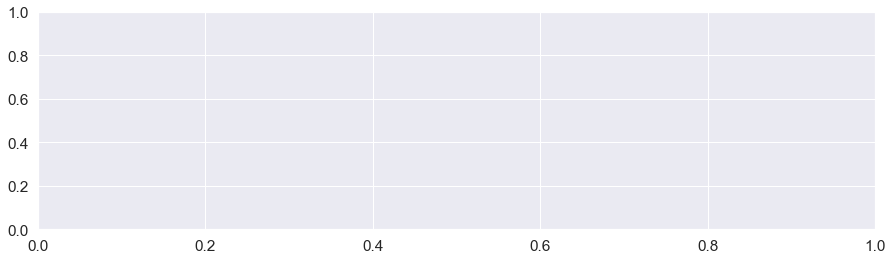

In [176]:
plt.close('all')
#fig, ((plt_sub1, plt_sub2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
fig, ((plt_sub1)) = plt.subplots(nrows=1, ncols=1, figsize=(15,4))

plot_metrics_test(plt_sub1, title='Softmax Score', metric_name='best_score', step_size=0.01, is_norm=False)
# plot_metrics_test(plt_sub2, title='Top-2 Difference', metric_name='Certainty', step_size=0.1, is_norm=False)

plt.show()
# plt.tight_layout()

## Entropy of Ensemble-Softmax [sum of entr(means)] & VAR
#### (Horizontal - Between classes [after averaging the results for the ensembles])

  7%|▋         | 7/96 [00:00<00:01, 61.67it/s]

max: 0.94233 .. min: 0.0 .. mean: 0.034286 .. var: 0.017099


 22%|██▏       | 9/41 [00:00<00:00, 88.77it/s]


When threshold=0.15:
..... 3.15% of correctly classified images are below the threshold
while 97.34% of incorrectly classified images are below the threshold
 threshold   unmatch     match      diff
 0.10       0.980676  0.042534  0.938142
 0.11       0.978261  0.039678  0.938583
 0.12       0.975845  0.037048  0.938797
 0.13       0.975845  0.035620  0.940225
 0.14       0.973430  0.033666  0.939763
 0.15       0.973430  0.031487  0.941943
 0.16       0.971014  0.029984  0.941030
 0.17       0.963768  0.028556  0.935212
 0.18       0.958937  0.027279  0.931658
 0.19       0.956522  0.025701  0.930821
max: 0.039931 .. min: 0.000691 .. mean: 0.038134 .. var: 4.5e-05


100%|██████████| 41/41 [00:00<00:00, 78.71it/s]



When threshold=0.03:
..... 2.71% of correctly classified images are below the threshold
while 96.86% of incorrectly classified images are below the threshold
 threshold   unmatch     match      diff
 0.024      0.937198  0.019989  0.917209
 0.025      0.944444  0.021417  0.923027
 0.026      0.951691  0.022920  0.928771
 0.027      0.954106  0.023897  0.930209
 0.028      0.956522  0.025475  0.931046
 0.029      0.968599  0.027129  0.941470
 0.030      0.968599  0.029082  0.939517
 0.031      0.968599  0.031562  0.937037
 0.032      0.971014  0.033892  0.937123
 0.033      0.975845  0.036898  0.938948


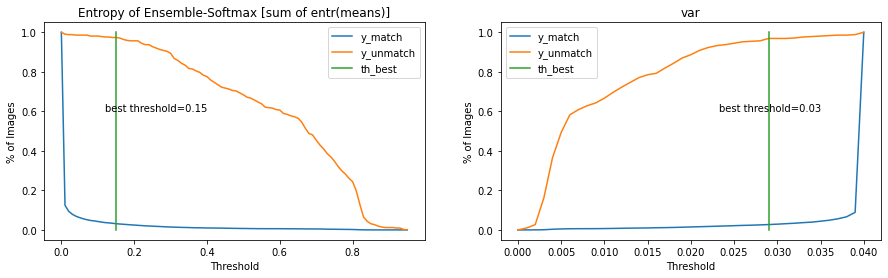

In [21]:
fig, ((plt_sub1, plt_sub2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
'''
here, we calculate the entropy of the mean of the predictions e.g.:
sm_e.i = Softmax value of the 'e'th ensemble of 'i'th class
ensemble_model1 = [sm_1.1, sm_1.2, ..., sm_1.24]
ensemble_model2 = [sm_2.1, sm_2.2, ..., sm_2.24]
sm1 = (sm_1.1 + sm_2.1)/2
ensemble_model_mean = [sm1, sm2, ..., sm24]
entropy will be calculated for ensemble_model_mean and sum of those individual means
HIGH entropy indicates HIGH information, which means HIGH UNCERTAINTY. so, we take the reverse of it 
to measure the certainty. THEN HIGH CERTAINTY is expected for CORRECTLY classified images.
LOW entropy indicates LOW information, which means LOW UNCERTAINTY=HIGH CERTAINTY.
NOTE: This entropy values normalized according to the highest possible entropy, so the max they can take is 1.0.
But since it is almost impossible have E_max, we see the max<1
'''

plot_metrics(plt_sub1, title='Entropy of Ensemble-Softmax [sum of entr(means)]', metric_name='u_entr',
             step_size=0.01, higher_better=False, is_norm=False)

'''
var will be calculated for ensemble_model_mean
HIGH variance indicates that the values are spreaded out from each other.
LOW variance indicates that the data points tend to be very close to the mean.
HIGH variance indicates that the data points are very spread out from the mean, and from one another.
so, we expect HIGHer variance value if there is a class which is much higher than others.
'''
plot_metrics(plt_sub2, title='var', metric_name='var', step_size=0.001, higher_better=True, is_norm=False)

plt.show()

## Bhattacharyya Coefficient & JSD

  8%|▊         | 2/26 [00:00<00:01, 14.33it/s]

max: 0.24802100658416748 .. min: 0.0 .. mean: 0.006963 .. var: 0.000651


  8%|▊         | 8/101 [00:00<00:01, 76.48it/s]


When threshold=0.25:
..... 100.0% of correctly classified images are below the threshold
while 100.0% of incorrectly classified images are below the threshold
 threshold   unmatch     match      diff
 0.20       0.971014  0.997971 -0.026956
 0.21       0.983092  0.998873 -0.015781
 0.22       0.985507  0.999098 -0.013591
 0.23       0.995169  0.999399 -0.004230
 0.24       0.997585  0.999775 -0.002190
 0.25       1.000000  1.000000  0.000000
max: 1.0 .. min: 0.588319 .. mean: 0.994841 .. var: 0.000567


100%|██████████| 101/101 [00:01<00:00, 72.54it/s]



When threshold=0.99:
..... 5.66% of correctly classified images are below the threshold
while 57.0% of incorrectly classified images are below the threshold
 threshold   unmatch     match      diff
 0.94       0.321256  0.018637  0.302619
 0.95       0.357488  0.021267  0.336221
 0.96       0.388889  0.025550  0.363338
 0.97       0.434783  0.030736  0.404047
 0.98       0.492754  0.040204  0.452549
 0.99       0.570048  0.056587  0.513462
 1.00       1.000000  1.000000  0.000000


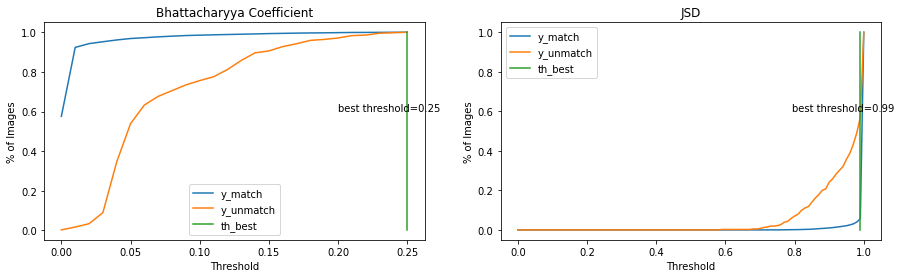

In [22]:
fig, ((plt_sub1, plt_sub2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
"""
Bhattacharyya Coefficient (BC):
The Bhattacharyya coefficient is a measure of the amount of overlap between 
two statistical samples or populations.
"""
df_results_eval['BC']=df_results_eval['best_score']*df_results_eval['best_2nd_score']
plot_metrics(plt_sub1, title='Bhattacharyya Coefficient', metric_name='BC', step_size=0.01, is_norm=False)
plot_metrics(plt_sub2, title='JSD', metric_name='P_jsd', step_size=0.01, higher_better=True, is_norm=False)

plt.show()

## var_Top1 (Vertical - Between ensembles)

  3%|▎         | 5/175 [00:00<00:04, 39.57it/s]

max: 0.173489 .. min: 0.0 .. mean: 0.001724 .. var: 0.000102


100%|██████████| 175/175 [00:03<00:00, 48.48it/s]



When threshold=0.16:
..... 99.99% of correctly classified images are below the threshold
while 100.0% of incorrectly classified images are below the threshold
 threshold   unmatch     match      diff
 0.155      0.997585  0.999925 -0.002340
 0.156      0.997585  0.999925 -0.002340
 0.157      0.997585  0.999925 -0.002340
 0.158      0.997585  0.999925 -0.002340
 0.159      0.997585  0.999925 -0.002340
 0.160      1.000000  0.999925  0.000075
 0.161      1.000000  0.999925  0.000075
 0.162      1.000000  0.999925  0.000075
 0.163      1.000000  0.999925  0.000075
 0.164      1.000000  0.999925  0.000075


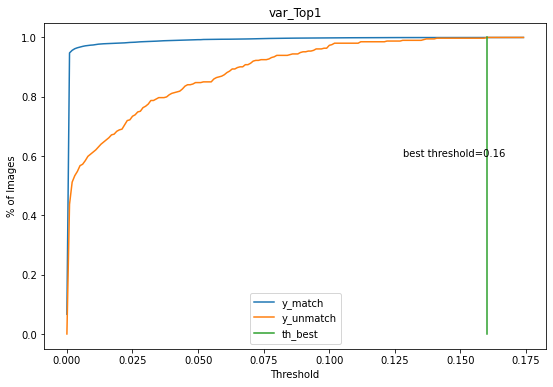

In [23]:
fig, ((plt_sub1)) = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
lst_var = []
'''
here, we calculate the variance of the best predictions among the ensemble members. e.g.:
sm_e.i = Softmax value of the 'e'th ensemble of 'i'th class
ensemble_model1 = [sm_1.1, sm_1.2, ..., sm_1.24]
ensemble_model2 = [sm_2.1, sm_2.2, ..., sm_2.24]
if the highest mean belongs to class_2, then
var will be calculated for sm_1.2 and sm_2.2
The variance in this case shows how much the models agree on a decision unlike the variance calculated
for the entire class results of mean-ensemble values.
'''

for x in df_results_eval.index:
    best_index = df_results_eval.loc[x, 'best_index']
    lst_var.append(np.var(tuc1.df_result_ensemble.loc[x, 'outputs_all'][:, best_index]))

df_results_eval['var_Top1'] = lst_var
# plot_metrics(title='var_Top1', metric_name='var_Top1', min_max_step=(0.9, 0.99, 0.01), is_norm=False)
plot_metrics(plt_sub1, title='var_Top1', metric_name='var_Top1', step_size=0.001, higher_better=True, is_norm=False)

#plot_metrics_p(plt_sub3, title='Softmax Score', metric_name='best_score', step_size=0.01, is_norm=False)

plt.show()

### Entropy (same as above (horizontal-entropy) but this time not normalized according to the max value)

  0%|          | 0/434 [00:00<?, ?it/s]

max: 4.320547 .. min: 0.0 .. mean: 0.1572 .. var: 0.359457


100%|██████████| 434/434 [00:05<00:00, 74.82it/s]



When threshold=0.71:
..... 3.08% of correctly classified images are below the threshold
while 97.34% of incorrectly classified images are below the threshold
 threshold   unmatch     match      diff
 0.66       0.973430  0.032690  0.940740
 0.67       0.973430  0.032088  0.941342
 0.68       0.973430  0.031863  0.941567
 0.69       0.973430  0.031412  0.942018
 0.70       0.973430  0.031111  0.942319
 0.71       0.973430  0.030811  0.942619
 0.72       0.971014  0.030435  0.940579
 0.73       0.971014  0.030135  0.940880
 0.74       0.971014  0.029533  0.941481
 0.75       0.971014  0.029308  0.941707


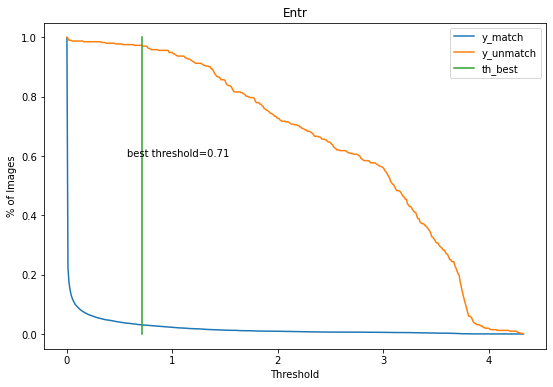

In [24]:
fig, ((plt_sub1)) = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
plot_metrics(plt_sub1, title='Entr', metric_name='entr', step_size=0.01, higher_better=False, is_norm=False)
plt.show()

## STD (Horizontal - Between classes [after averaging the results for the ensembles])

  0%|          | 0/201 [00:00<?, ?it/s]

max: 0.199826 .. min: 0.026284 .. mean: 0.193773 .. var: 0.000586


100%|██████████| 201/201 [00:02<00:00, 94.89it/s]



When threshold=0.17:
..... 2.74% of correctly classified images are below the threshold
while 96.86% of incorrectly classified images are below the threshold
 threshold   unmatch     match      diff
 0.166      0.956522  0.024574  0.931948
 0.167      0.956522  0.025250  0.931272
 0.168      0.958937  0.025851  0.933086
 0.169      0.961353  0.026377  0.934976
 0.170      0.966184  0.026903  0.939280
 0.171      0.968599  0.027429  0.941170
 0.172      0.968599  0.028256  0.940343
 0.173      0.968599  0.029007  0.939592
 0.174      0.968599  0.029984  0.938615
 0.175      0.968599  0.030585  0.938014


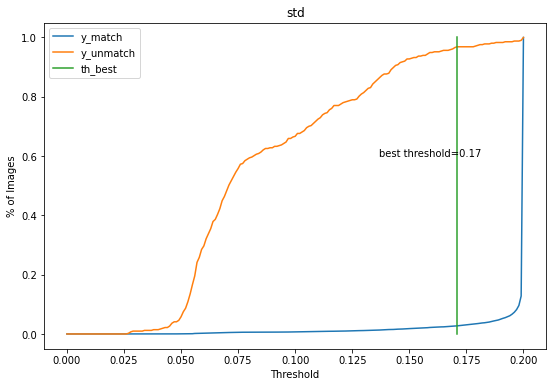

In [25]:
#plot_metrics(title='std', metric_name='std', min_max_step=(0.9, 0.99, 0.01), is_norm=False)
fig, ((plt_sub1)) = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
plot_metrics(plt_sub1, title='std', metric_name='std', step_size=0.001, higher_better=True, is_norm=False)
plt.show()

In [26]:
#tuc1.df_result_ensemble[:1]
pd.set_option('display.max_columns', None)
df_results_eval[:1]

uncertainty actual_class best_pred best_2nd_pred best_score best_2nd_score  \
0  0           9            9         8             1          0               

  class_idx best_index best_2nd_index         entr       u_entr  \
0  8         8          7              1.98113e-05  4.32093e-06   

                            picture        model P_jsd    P_info          jsd  \
0  MA160814197500042.017-K_9_0_.png  densenet121  1     0.999996  6.84872e-07   

         sum_H        H_sum  \
0  1.91264e-05  1.98113e-05   

                                                                                                                                                                                                                                                                                                                                                            Mean  \
0  [3.1362077e-10, 1.7655319e-07, 2.1755039e-11, 5.691735e-09, 7.638415e-09, 3.8511802e-10, 2.3192279e-10, 6.436275e-07, 0.9999992, 1.00515845e-08, 1.7852149e-09, 1.684025e-09, 3.9874792e-10, 8.959348e-09, 8.03346e-10, 7.0129724e-09, 6.5937718e-09, 1.25014304e-11, 3.1121292e-13, 1.9151862e-09, 1.436468e-10, 6.9528583e-10, 1.7408253e-10, 6.631638e-11]   

        std      var Certainty BC      var_Top1  
0  0.199826  0.03993  100       0  8.732570e-13

In [27]:
tuc1.show_results(result = 'ALL') # mean=mean top-2 uncertainty of the given class

Mean for ALL: 0.033


sum  count      mean      entr    u_entr
actual_class                                              
1             8.5192   598    0.014246  0.068165  0.014867
10            12.0240  578    0.020803  0.100869  0.022000
11            12.6256  593    0.021291  0.112117  0.024453
12            9.7902   585    0.016735  0.077072  0.016810
13            63.6775  648    0.098268  0.457718  0.099830
14            49.0946  627    0.078301  0.358450  0.078180
15            36.4650  609    0.059877  0.273070  0.059558
16            9.4533   579    0.016327  0.082351  0.017961
17            12.8120  582    0.022014  0.123498  0.026935
18            12.0994  588    0.020577  0.098376  0.021456
19            16.1062  585    0.027532  0.133343  0.029083
2             12.5334  600    0.020889  0.117535  0.025635
20            15.7256  579    0.027160  0.134295  0.029290
21            49.5330  637    0.077760  0.370020  0.080703
22            32.6408  605    0.053952  0.264586  0.057707
3             9.1312   595    0.015347  0.069199  0.015093
4             11.8256  592    0.019976  0.104630  0.022820
5             8.4959   591    0.014375  0.073752  0.016086
6             9.0527   601    0.015063  0.077364  0.016873
7             7.7298   584    0.013236  0.073627  0.016058
8             16.5063  591    0.027929  0.124311  0.027113
9             11.7758  583    0.020199  0.096668  0.021084
x             7.6815   440    0.017458  0.088589  0.019322
y             11.0921  151    0.073458  0.358914  0.078281

In [28]:
xx=np.array([1,2,8,4,5])
np.argmax(xx)

2

In [29]:
tuc1.show_results(result = 'match')

Mean for match: 0.0152


sum  count      mean      entr    u_entr
actual_class                                              
1             2.9056   589    0.004933  0.029751  0.006489
10            5.1660   564    0.009160  0.049776  0.010856
11            3.5711   577    0.006189  0.046729  0.010192
12            3.6038   576    0.006257  0.032893  0.007174
13            40.9448  619    0.066147  0.329830  0.071937
14            10.9040  574    0.018997  0.098954  0.021582
15            7.2120   571    0.012630  0.078284  0.017074
16            6.2826   571    0.011003  0.057143  0.012463
17            5.9415   571    0.010405  0.071611  0.015619
18            3.5583   576    0.006178  0.037157  0.008104
19            7.8026   572    0.013641  0.071324  0.015556
2             5.4580   587    0.009298  0.062792  0.013695
20            7.3230   562    0.013030  0.076928  0.016778
21            19.0878  591    0.032297  0.170179  0.037117
22            11.4546  573    0.019991  0.114089  0.024883
3             4.5574   587    0.007764  0.037436  0.008165
4             5.9942   580    0.010335  0.053528  0.011675
5             4.6782   584    0.008011  0.043569  0.009503
6             4.2746   591    0.007233  0.041089  0.008962
7             2.6851   575    0.004670  0.029800  0.006500
8             4.0620   569    0.007139  0.047138  0.010281
9             2.3284   567    0.004107  0.030387  0.006628
x             5.5245   434    0.012729  0.057110  0.012456
y             9.0362   147    0.061471  0.303618  0.066220

In [30]:
tuc1.show_results(result = 'unmatch')

Mean for unmatch: 0.5853


sum  count      mean      entr    u_entr
actual_class                                              
1             5.6136   9      0.623733  2.582150  0.563178
10            6.8580   14     0.489857  2.159180  0.470926
11            9.0545   16     0.565906  2.470193  0.538760
12            6.1864   9      0.687378  2.904548  0.633494
13            22.7327  29     0.783886  3.187466  0.695200
14            38.1906  53     0.720577  3.168840  0.691138
15            29.2530  38     0.769816  3.199984  0.697930
16            3.1707   8      0.396338  1.881519  0.410367
17            6.8705   11     0.624591  2.816909  0.614380
18            8.5411   12     0.711758  3.036877  0.662356
19            8.3036   13     0.638738  2.862156  0.624249
2             7.0754   13     0.544262  2.589375  0.564754
20            8.4026   17     0.494271  2.030789  0.442924
21            30.4452  46     0.661852  2.937533  0.640688
22            21.1862  32     0.662069  2.959422  0.645463
3             4.5738   8      0.571725  2.399783  0.523403
4             5.8314   12     0.485950  2.574596  0.561530
5             3.8177   7      0.545386  2.591873  0.565299
6             4.7781   10     0.477810  2.221196  0.484452
7             5.0447   9      0.560522  2.873633  0.626752
8             12.4443  22     0.565650  2.120283  0.462443
9             9.4474   16     0.590462  2.445512  0.533377
x             2.1570   6      0.359500  2.365545  0.515935
y             2.0559   4      0.513975  2.391065  0.521502

In [31]:
tuc1.show_results(result = 'combined')

count_all  count_match  count_unmatch  accuracy  mean_all  \
actual_class                                                              
1             598        589          9              0.9849    0.014246   
10            578        564          14             0.9758    0.020803   
11            593        577          16             0.9730    0.021291   
12            585        576          9              0.9846    0.016735   
13            648        619          29             0.9552    0.098268   
14            627        574          53             0.9155    0.078301   
15            609        571          38             0.9376    0.059877   
16            579        571          8              0.9862    0.016327   
17            582        571          11             0.9811    0.022014   
18            588        576          12             0.9796    0.020577   
19            585        572          13             0.9778    0.027532   
2             600        587          13             0.9783    0.020889   
20            579        562          17             0.9706    0.027160   
21            637        591          46             0.9278    0.077760   
22            605        573          32             0.9471    0.053952   
3             595        587          8              0.9866    0.015347   
4             592        580          12             0.9797    0.019976   
5             591        584          7              0.9882    0.014375   
6             601        591          10             0.9834    0.015063   
7             584        575          9              0.9846    0.013236   
8             591        569          22             0.9628    0.027929   
9             583        567          16             0.9726    0.020199   
x             440        434          6              0.9864    0.017458   
y             151        147          4              0.9735    0.073458   

              entropy_all  u_entropy_all  mean_match  entropy_match  \
actual_class                                                          
1             0.068165     0.014867       0.004933    0.029751        
10            0.100869     0.022000       0.009160    0.049776        
11            0.112117     0.024453       0.006189    0.046729        
12            0.077072     0.016810       0.006257    0.032893        
13            0.457718     0.099830       0.066147    0.329830        
14            0.358450     0.078180       0.018997    0.098954        
15            0.273070     0.059558       0.012630    0.078284        
16            0.082351     0.017961       0.011003    0.057143        
17            0.123498     0.026935       0.010405    0.071611        
18            0.098376     0.021456       0.006178    0.037157        
19            0.133343     0.029083       0.013641    0.071324        
2             0.117535     0.025635       0.009298    0.062792        
20            0.134295     0.029290       0.013030    0.076928        
21            0.370020     0.080703       0.032297    0.170179        
22            0.264586     0.057707       0.019991    0.114089        
3             0.069199     0.015093       0.007764    0.037436        
4             0.104630     0.022820       0.010335    0.053528        
5             0.073752     0.016086       0.008011    0.043569        
6             0.077364     0.016873       0.007233    0.041089        
7             0.073627     0.016058       0.004670    0.029800        
8             0.124311     0.027113       0.007139    0.047138        
9             0.096668     0.021084       0.004107    0.030387        
x             0.088589     0.019322       0.012729    0.057110        
y             0.358914     0.078281       0.061471    0.303618        

              u_entropy_match  mean_unmatch  entropy_unmatch  \
actual_class                                                   
1             0.006489         0.623733      2.582150          
10            0.010856  

In [32]:
pd.set_option('display.max_rows', None)
tuc1.show_results(result = 'ALL2nd')

Mean for ALL2nd: 0.2436


sum  count      mean      entr  \
actual_class best_pred best_2nd_pred                                       
1            1         10             0.0227   16     0.001419  0.025429   
                       11             0.0419   69     0.000607  0.012949   
                       12             0.0208   43     0.000484  0.009123   
                       13             0.1133   12     0.009442  0.191142   
                       14             0.0575   3      0.019167  0.405877   
                       15             0.0039   16     0.000244  0.008331   
                       16             0.0156   127    0.000123  0.002079   
                       18             0.0006   1      0.000600  0.034109   
                       19             0.0027   19     0.000142  0.002875   
                       2              0.6914   182    0.003799  0.025006   
                       22             0.0025   2      0.001250  0.069402   
                       3              1.2074   30     0.040247  0.085227   
                       4              0.0341   7      0.004871  0.075724   
                       6              0.0137   10     0.001370  0.018720   
                       7              0.0306   33     0.000927  0.015614   
                       8              0.0152   5      0.003040  0.061741   
                       x              0.6317   14     0.045121  0.217505   
             12        1              0.3185   1      0.318500  1.821627   
             13        14             1.5105   2      0.755250  3.763026   
                       21             0.9016   1      0.901600  3.289016   
             2         1              0.2067   1      0.206700  1.682310   
                       12             0.2387   1      0.238700  2.100612   
             21        14             0.8799   1      0.879900  3.178083   
             22        20             0.9748   1      0.974800  1.390760   
             9         10             0.5829   1      0.582900  2.250891   
10           1         x              0.4830   1      0.483000  2.071181   
             10        1              0.0410   7      0.005857  0.098793   
                       11             0.0192   8      0.002400  0.031744   
                       12             0.0017   3      0.000567  0.017884   
                       13             0.0015   2      0.000750  0.015934   
                       14             0.0111   15     0.000740  0.017526   
                       15             0.0225   2      0.011250  0.151846   
                       16             1.3169   113    0.011654  0.052311   
                       18             1.2628   25     0.050512  0.243091   
                       2              0.0420   85     0.000494  0.009742   
                       20             0.0759   24     0.003163  0.029726   
                       22             0.0000   1      0.000000  0.000361   
                       3              0.0154   2      0.007700  0.149058   
                       6              0.5726   92     0.006224  0.048964   
                       7              1.0516   79     0.013311  0.045870   
                       8              0.0043   3      0.001433  0.028297   
                       9              0.4338   98     0.004427  0.031500   
                       x              0.2937   5      0.058740  0.269518   
             12        11             0.3293   1      0.329300  1.166451   
                       15             0.6273   1      0.627300  3.079189   
             13        14             0.6423   1      0.642300  3.743697   
             18        16             0.2844   1      0.284400  2.524561   
             4         6              0.2034   1      0.203400  1.794914   
             6         13             0.6642   1      0.664200  2.867487   
             7         10             0.5567   1      0.556700  1.666722   
                       8              0.9421   1      0.942100  2.204677   
             8

In [33]:
df_results_eval[df_results_eval['actual_class'] != 
                df_results_eval['best_pred']].loc[:,['picture','actual_class', 'best_pred', 'Certainty']]

picture actual_class best_pred  \
2      MA160873676300027.057-K_20_1_.png       20           9          
52     MA160873676300003.074-K_8_0_.png        8            14         
53     MA160873676300007.009-K_22_0_.png       22           13         
145    MA160873676300003.066-K_5_2_.png        5            13         
169    MA160814197500040.056-K_x_1_.png        x            4          
243    MA1867835.035-K_2_2_.png                2            13         
244    MA160873676300031.083-K_22_1_.png       22           19         
263    MA160873676300043.078-K_18_3_.png       18           13         
293    MA160873676300043.020-K_13_1_.png       13           y          
343    MA1867826.077-K_14_0_.png               14           21         
346    MA1867833.002-K_14_2_.png               14           21         
404    MA1867835.003-K_17_2_.png               17           13         
540    MA160873676300003.066-K_2_1_.png        2            3          
560    MA160814197500041.064-K_22_1_.png       22           21         
706    MA160873676300041.006-K_21_1_.png       21           19         
715    MA160814197500043.086-K_5_1_.png        5            3          
725    MA160873676300031.017-K_16_1_.png       16           19         
778    MA1867829.031-K_4_1_.png                4            5          
779    MA160814197500004.054-K_16_2_.png       16           13         
787    MA160873676300016.101-K_13_0_.png       13           21         
826    MA160873676300016.034-K_9_2_.png        9            13         
846    MA160814197500043.101-K_17_0_.png       17           12         
910    MA1867835.045-K_22_0_.png               22           21         
911    MA160814197500026.058-K_13_0_.png       13           14         
917    MA83756160814197500052.015-K_12_2_.png  12           22         
999    MA1867832.070-K_21_0_.png               21           13         
1029   MA160873676300031.083-K_14_1_.png       14           13         
1036   MA160865191500021.030-K_11_2_.png       11           22         
1042   MA160814197500004.012-K_19_2_.png       19           13         
1044   MA160814197500042.017-K_14_0_.png       14           21         
1061   MA160814197500040.074-K_6_0_.png        6            x          
1119   MA160814197500004.076-K_15_1_.png       15           13         
1124   MA160873676300007.006-K_22_0_.png       22           21         
1142   MA160865191500027.025-K_12_0_.png       12           15         
1174   MA160814197500041.070-K_21_0_.png       21           22         
1191   MA160814197500043.101-K_8_0_.png        8            21         
1205   MA160814197500004.059-K_20_0_.png       20           16         
1208   MA1867829.041-K_10_0_.png               10           7          
1247   MA160814197500040.002-K_14_2_.png       14           15         
1271   MA160814197500041.058-K_22_0_.png       22           21         
1314   MA1867835.104-K_9_0_.png                9            4          
1317   MA1867832.021-K_15_2_.png               15           13         
1325   MA1867835.092-K_13_0_.png               13           22         
1383   MA1867835.062-K_4_2_.png                4            13         
1385   MA160873676300031.082-K_4_1_.png        4            9          
1396   MA160814197500026.075-K_11_0_.png       11           15         
1446   MA160865191500027.003-K_17_0_.png       17           20         
1491   MA160814197500026.041-K_9_2_.png        9            13         
1492   MA1867832.070-K_15_1_.png               15           13         
1524   MA160814197500026.075-K_20_0_.png       20           15         
1561   MA1867835.096-K_16_0_.png               16           18         
1573   MA1867835.096-K_15_0_.png               15           13         
1591   MA160865191500021.018-K_2_3_.png        2            13         
1595   MA1867826.021-K_13_0_.png               13           21         
1645   MA160873676300003.071-K_2_1_.png        2            6          
1653  

In [34]:
df_results_eval.loc[2,:]

uncertainty       0.4798                                                                                                                                                                                                                                                                                                                                    
actual_class      20                                                                                                                                                                                                                                                                                                                                        
best_pred         9                                                                                                                                                                                                                                                                                           

In [35]:
tuc1.df_uncertainty.loc[2,:]

uncertainty       0.4798                                                                                                                                                                                                                                                                                                                                    
actual_class      20                                                                                                                                                                                                                                                                                                                                        
best_pred         9                                                                                                                                                                                                                                                                                           

In [36]:
df_results_eval[df_results_eval['actual_class'] == 
                df_results_eval['best_pred']].loc[:,['picture','actual_class', 'best_pred', 'Certainty']]


picture actual_class best_pred Certainty
0      MA160814197500042.017-K_9_0_.png        9            9         100     
1      MA160814197500041.070-K_4_0_.png        4            4         100     
3      MA1867826.007-K_22_0_.png               22           22        99.95   
4      MA1867835.121-K_7_1_.png                7            7         99.9299 
5      MA160814197500062.005-K_15_1_.png       15           15        100     
6      MA160873676300016.059-K_10_0_.png       10           10        100     
7      MA160865191500037.027-K_21_0_.png       21           21        99.98   
8      MA1867826.007-K_6_1_.png                6            6         100     
9      MA160814197500025.093-K_11_1_.png       11           11        99.9599 
10     MA160865191500042.015-K_9_1_.png        9            9         98.708  
11     MA160873676300043.117-K_1_1_.png        1            1         98.915  
12     MA1867835.104-K_19_0_.png               19           19        99.99   
13     MA1867832.032-K_12_0_.png               12           12        99.8999 
14     MA160814197500042.015-K_12_1_.png       12           12        100     
15     MA160865191500042.002-K_14_1_.png       14           14        100     
16     MA1867829.041-K_14_1_.png               14           14        100     
17     MA160814197500038.021-K_21_0_.png       21           21        99.99   
18     MA160814197500056.011-K_6_0_.png        6            6         100     
19     MA160814197500026.058-K_12_0_.png       12           12        94.5307 
20     MA160814197500025.097-K_16_0_.png       16           16        100     
21     MA83756160814197500052.015-K_12_1_.png  12           12        100     
22     MA160873676300007.006-K_14_1_.png       14           14        100     
23     MA1867829.041-K_21_2_.png               21           21        99.5365 
24     MA160814197500059.065-K_2_0_.png        2            2         100     
25     MA1867835.045-K_16_0_.png               16           16        99.99   
26     MA1867833.045-K_x_0_.png                x            x         99.98   
27     MA160814197500025.093-K_4_1_.png        4            4         83.5305 
28     MA160814197500025.099-K_8_0_.png        8            8         98.8073 
29     MA160873676300039.010-K_10_1_.png       10           10        100     
30     MA160814197500040.002-K_6_0_.png        6            6         99.98   
31     MA160814197500004.093-K_8_0_.png        8            8         100     
32     MA160873676300031.083-K_16_1_.png       16           16        100     
33     MA160814197500004.081-K_22_1_.png       22           22        100     
34     MA1867832.123-K_14_0_.png               14           14        99.9198 
35     MA160873676300039.018-K_2_1_.png        2            2         100     
36     MA1867826.034-K_8_1_.png                8            8         100     
37     MA160814197500042.004-K_19_0_.png       19           19        98.1762 
38     MA1867833.023-K_20_1_.png               20           20        78.5059 
39     MA1867826.007-K_18_0_.png               18           18        100     
40     MA160865191500045.002-K_17_0_.png       17           17        100     
41     MA160814197500042.012-K_21_3_.png       21           21        100     
42     MA160865191500046.004-K_12_1_.png       12           12        100     
43     MA1867833.015-K_13_0_.png               13           13        3.64611 
44     MA160814197500041.028-K_12_0_.png       12           12        100     
45     MA160814197500043.115-K_15_0_.png       15           15        100     
46     MA160873676300019.018-K_17_0_.png       17           17        100     
47     MA160873676300031.039-K_5_1_.png        5            5         99.99   
48     MA160814197500026.062-K_7_2_.png        7            7         99.8998 
49     MA160814197500059.044-K_22_1_.png       22           22        99.96   
50     MA160865191500014.009-K_18_0_.png       18           18        100     
51     MA

Confusion matrix, without normalization
[[589   0   0   1   3   0   0   0   0   0   0   2   0   1   1   0   0   0
    0   0   0   1   0   0]
 [  1 564   0   2   1   0   0   0   0   1   0   0   0   0   0   0   1   0
    1   2   1   2   2   0]
 [  0   2 577   2   2   0   1   0   0   0   0   0   0   0   2   0   0   0
    4   0   0   3   0   0]
 [  0   0   0 576   3   1   2   0   0   0   0   0   0   1   1   0   0   1
    0   0   0   0   0   0]
 [  0   0   0   0 619   8   2   0   0   0   0   0   0  13   3   0   0   0
    0   0   0   1   1   1]
 [  0   0   0   0  18 574   4   1   2   1   0   0   1  17   6   0   0   0
    0   0   0   0   2   1]
 [  0   0   0   0  19   2 571   0   1   0   2   0   0   5   6   0   1   0
    2   0   0   0   0   0]
 [  0   0   0   0   2   0   0 571   1   1   1   1   0   0   0   0   0   0
    0   0   0   1   1   0]
 [  0   0   0   2   4   1   0   0 571   1   0   0   1   1   1   0   0   0
    0   0   0   0   0   0]
 [  1   0   0   0   5   1   1   1   0 576   0   0  

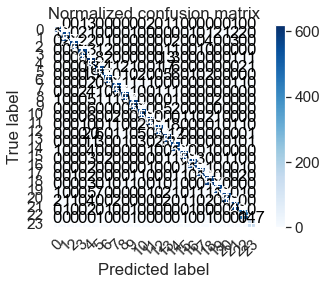

In [74]:
import itertools
plt.figure()
class_names = range(24)
plot_confusion_matrix(confusion, classes=class_names, normalize=False,title='Normalized confusion matrix')
# plot_confusion_matrix(confusion, normalize=True,title='Normalized confusion matrix')

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

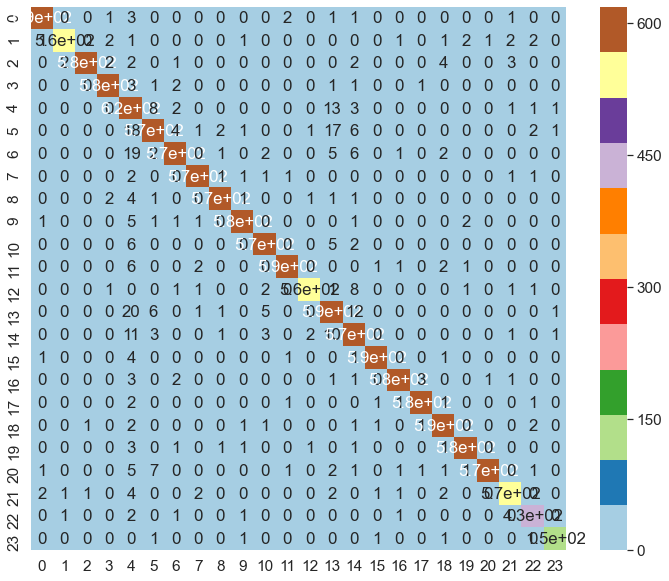

In [37]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
l_label = list(df_final['actual_class'])
l_pred = list(df_final['best_pred'])
performance.plot_confusion_matrix(l_label, l_pred)

In [75]:
cnf_matrix = confusion_matrix(l_label, l_pred)
cnf_matrix

array([[589,   0,   0,   1,   3,   0,   0,   0,   0,   0,   0,   2,   0,
          1,   1,   0,   0,   0,   0,   0,   0,   1,   0,   0],
       [  1, 564,   0,   2,   1,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   1,   0,   1,   2,   1,   2,   2,   0],
       [  0,   2, 577,   2,   2,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   2,   0,   0,   0,   4,   0,   0,   3,   0,   0],
       [  0,   0,   0, 576,   3,   1,   2,   0,   0,   0,   0,   0,   0,
          1,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 619,   8,   2,   0,   0,   0,   0,   0,   0,
         13,   3,   0,   0,   0,   0,   0,   0,   1,   1,   1],
       [  0,   0,   0,   0,  18, 574,   4,   1,   2,   1,   0,   0,   1,
         17,   6,   0,   0,   0,   0,   0,   0,   0,   2,   1],
       [  0,   0,   0,   0,  19,   2, 571,   0,   1,   0,   2,   0,   0,
          5,   6,   0,   1,   0,   2,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   2,   0,   0

In [98]:
#https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826#:~:text=False%20Positive%20(FP)%3A%20It,the%20positive%20class%20as%20negative.
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [177]:
ACC*100

array([99.89067852, 99.86881423, 99.86881423, 99.87610232, 98.87763283,
       99.39508782, 99.61373078, 99.88339042, 99.86881423, 99.85423803,
       99.80322134, 99.86152613, 99.83966183, 99.23474965, 99.41695212,
       99.90525472, 99.86152613, 99.90525472, 99.81050944, 99.88339042,
       99.82508564, 99.80322134, 99.87610232, 99.94169521])

In [179]:
(sum_TP)/(sum_TP+sum_FP)

0.9698272720647183

In [110]:
sum_TP = sum(TP)
sum_TN = sum(TN)
sum_FN = sum(FN)
sum_FP = sum(FP)
sum_FN/(sum_TP+sum_FN)

0.030172727935281685

In [100]:
(sum_TP+sum_TN)/(sum_TP+sum_FP+sum_FN+sum_TN)

0.9974856060053932

In [109]:
np.mean(FNR)

0.02794764443453023

In [103]:
sum_FN/(sum_TP+sum_FN)

0.030172727935281685

In [38]:
l_label_idx = list(df_final['class_idx'])
l_pred_idx = list(df_final['best_index'])
l_predict_proba = list(df_final['Mean'])
roc_auc_score(l_label_idx, l_predict_proba, multi_class='ovr')

0.9995367474167344

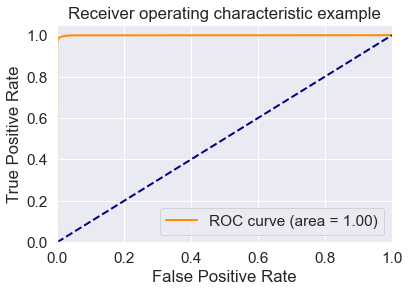

In [39]:
fpr = dict()
tpr = dict()
roc_auc = dict()

arr_label_idx = np.array(l_label_idx).reshape(-1,1)
arr_predict_proba = np.array(l_predict_proba)

#label_encoder = LabelEncoder()
#l_label_int = label_encoder.fit_transform(l_label_int)    
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(arr_label_idx)   # onehot_encoded => array(852,24)=(n_samples, n_classes)

# Compute micro-average ROC curve and ROC area
fpr["ALL"], tpr["ALL"], _ = roc_curve(onehot_encoded.ravel(), arr_predict_proba.ravel())
roc_auc["ALL"] = auc(fpr["ALL"], tpr["ALL"])

plt.figure()
lw = 2
plt.plot(fpr["ALL"], tpr["ALL"], color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["ALL"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

fpr_ALL, tpr_ALL, roc_auc_val = fpr['ALL'], tpr['ALL'], roc_auc["ALL"]
# print(f"fpr_ALL: {fpr_ALL} .. ttpr_ALL: {tpr_ALL} .. roc_auc_val: {roc_auc_val}")


In [40]:
len(arr_label_idx)

13721

In [104]:
# print(metrics.confusion_matrix(l_label, l_pred))
print(metrics.classification_report(l_label, l_pred, digits=4))

              precision    recall  f1-score   support

           1     0.9899    0.9849    0.9874       598
          10     0.9930    0.9758    0.9843       578
          11     0.9965    0.9730    0.9846       593
          12     0.9863    0.9846    0.9855       585
          13     0.8320    0.9552    0.8894       648
          14     0.9503    0.9155    0.9326       627
          15     0.9744    0.9376    0.9556       609
          16     0.9862    0.9862    0.9862       579
          17     0.9879    0.9811    0.9845       582
          18     0.9863    0.9796    0.9829       588
          19     0.9761    0.9778    0.9769       585
           2     0.9899    0.9783    0.9841       600
          20     0.9912    0.9706    0.9808       579
          21     0.9092    0.9278    0.9184       637
          22     0.9227    0.9471    0.9347       605
           3     0.9916    0.9866    0.9890       595
           4     0.9881    0.9797    0.9839       592
           5     0.9898    

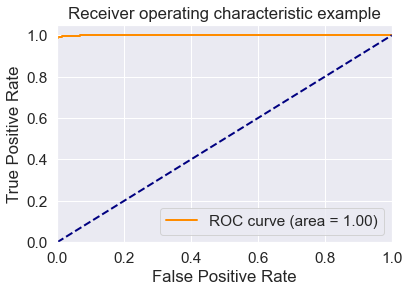

0.9996


In [42]:
arr_label_idx = np.array(l_label_idx).reshape(-1,1)
arr_predict_proba = np.array(l_predict_proba)

# plt_class = for which class you want to plot the ROC CURVE
fpr_micro, tpr_micro, roc_auc_val = \
performance.plot_roc_curve(arr_label_idx, arr_predict_proba, n_classes=24, plt_class=22)

print(round(roc_auc_val,4))

In [43]:
df_results_eval.iloc[0:10]

uncertainty actual_class best_pred best_2nd_pred best_score best_2nd_score  \
0  0           9            9         8             1          0               
1  0           4            4         5             1          0               
2  0.4798      20           9         20            0.6154     0.2953          
3  0.0005      22           22        19            0.9992     0.0005          
4  0.0007      7            7         5             0.9991     0.0007          
5  0           15           15        20            1          0               
6  0           10           10        16            1          0               
7  0.0002      21           21        14            0.9992     0.0002          
8  0           6            6         3             1          0               
9  0.0004      11           11        17            0.9987     0.0004          

  class_idx best_index best_2nd_index         entr       u_entr  \
0  8         8          7              1.98113e-05  4.32093e-06   
1  3         3          4              0.000215585  4.70201e-05   
2  19        8          19             1.50305      0.327822      
3  21        21         18             0.0103708    0.00226192    
4  6         6          4              0.0116466    0.00254018    
5  14        14         19             7.80758e-05  1.70287e-05   
6  9         9          15             5.99894e-05  1.30839e-05   
7  20        20         13             0.0114784    0.00250349    
8  5         5          2              8.93348e-06  1.94843e-06   
9  10        10         16             0.0180226    0.0039308     

                             picture        model     P_jsd    P_info  \
0  MA160814197500042.017-K_9_0_.png   densenet121  1         0.999996   
1  MA160814197500041.070-K_4_0_.png   densenet121  0.999998  0.999954   
2  MA160873676300027.057-K_20_1_.png  densenet121  0.941017  0.702048   
3  MA1867826.007-K_22_0_.png          densenet121  0.999877  0.9978     
4  MA1867835.121-K_7_1_.png           densenet121  0.99986   0.997531   
5  MA160814197500062.005-K_15_1_.png  densenet121  0.999998  0.999984   
6  MA160873676300016.059-K_10_0_.png  densenet121  0.999999  0.999987   
7  MA160865191500037.027-K_21_0_.png  densenet121  0.999867  0.997564   
8  MA1867826.007-K_6_1_.png           densenet121  1         0.999998   
9  MA160814197500025.093-K_11_1_.png  densenet121  0.999557  0.996294   

           jsd        sum_H        H_sum  \
0  6.84872e-07  1.91264e-05  1.98113e-05   
1  4.79229e-06  0.000210793  0.000215585   
2  0.136955     1.3661       1.50305       
3  0.000285785  0.010085     0.0103708     
4  0.000325151  0.0113215    0.0116466     
5  3.49919e-06  7.45766e-05  7.80758e-05   
6  1.69405e-06  5.82954e-05  5.99894e-05   
7  0.000309068  0.0111693    0.0114784     
8  3.51268e-07  8.58221e-06  8.93348e-06   
9  0.00102954   0.016993     0.0180226     

                                                                                                                                                                                                                                                                                                                                                                Mean  \
0  [3.1362077e-10, 1.7655319e-07, 2.1755039e-11, 5.691735e-09, 7.638415e-09, 3.8511802e-10, 2.3192279e-10, 6.436275e-07, 0.9999992, 1.00515845e-08, 1.7852149e-09, 1.684025e-09, 3.9874792e-10, 8.959348e-09, 8.03346e-10, 7.0129724e-09, 6.5937718e-09, 1.25014304e-11, 3.1121292e-13, 1.9151862e-09, 1.436468e-10, 6.9528583e-10, 1.7408253e-10, 6.631638e-11]       
1  [4.615979e-07, 1.0511314e-09, 1.3410795e-09, 0.9999889, 7.5094313e-06, 3.8386172e-08, 3.758729e-08, 3.899335e-09, 9.887815e-10, 1.8684148e-08, 5.164881e-08, 5.232544e-07, 1.0412538e-06, 8.876268e-09, 1.3623682e-07, 9.187849e-09, 1.4810335e-09, 1.4965476e-08, 4.2680952e-08, 7.0883516e-07, 5.381078e-10, 8.351164e-10, 2.814524e-07, 3.6715925e-08]           
2  [2.1932088e

In [44]:
pd.set_option('display.max_columns', None)
df_results_eval[df_results_eval['picture']=='MA160814197500042.017-K_9_0_.png']

uncertainty actual_class best_pred best_2nd_pred best_score best_2nd_score  \
0  0           9            9         8             1          0               

  class_idx best_index best_2nd_index         entr       u_entr  \
0  8         8          7              1.98113e-05  4.32093e-06   

                            picture        model P_jsd    P_info          jsd  \
0  MA160814197500042.017-K_9_0_.png  densenet121  1     0.999996  6.84872e-07   

         sum_H        H_sum  \
0  1.91264e-05  1.98113e-05   

                                                                                                                                                                                                                                                                                                                                                            Mean  \
0  [3.1362077e-10, 1.7655319e-07, 2.1755039e-11, 5.691735e-09, 7.638415e-09, 3.8511802e-10, 2.3192279e-10, 6.436275e-07, 0.9999992, 1.00515845e-08, 1.7852149e-09, 1.684025e-09, 3.9874792e-10, 8.959348e-09, 8.03346e-10, 7.0129724e-09, 6.5937718e-09, 1.25014304e-11, 3.1121292e-13, 1.9151862e-09, 1.436468e-10, 6.9528583e-10, 1.7408253e-10, 6.631638e-11]   

        std      var Certainty BC      var_Top1  
0  0.199826  0.03993  100       0  8.732570e-13

In [45]:
df_results_eval.columns

Index(['uncertainty', 'actual_class', 'best_pred', 'best_2nd_pred',
       'best_score', 'best_2nd_score', 'class_idx', 'best_index',
       'best_2nd_index', 'entr', 'u_entr', 'picture', 'model', 'P_jsd',
       'P_info', 'jsd', 'sum_H', 'H_sum', 'Mean', 'std', 'var', 'Certainty',
       'BC', 'var_Top1'],
      dtype='object')

In [46]:
# df_results_eval
# output = tuc1.softmax_and_reshape(tuc1.df_result_ensemble.loc[0,'outputs_all'])
# output

In [47]:
# from scipy.special import entr
# entr(output[:,8]).sum()

In [48]:

# entr_per_model=entr(output).sum(axis=1)/np.log(2)
# entr_per_model2=entr(output).sum(axis=0)/np.log(2)
# print(entr_per_model)
# print(np.mean(entr_per_model))
# print(entr_per_model2)
# print(np.mean(entr_per_model2))

In [49]:
# x=0
# # variance of the scores of the best prediction (pred with the highest score)
# # indexes are preserved between 2 dataframes
# np.var(tuc1.normalize_array_preprocess(tuc1.df_result_ensemble.loc[x,
#                                         'outputs_all'])[:,df_results_eval.loc[x,'best_index']])


In [50]:
for i in range(len(df_results_eval)):
    if i %1000 == 0:
        pic1 = df_results_eval.loc[i,'picture']
        pic2 = tuc1.df_result_ensemble.loc[i,'picture']
        print(f'df_results_eval: {pic1} ... df_result_ensemble: {pic2}')
    if df_results_eval.loc[i,'picture'] != tuc1.df_result_ensemble.loc[i,'picture']:
        print('mismatch')

df_results_eval: MA160814197500042.017-K_9_0_.png ... df_result_ensemble: MA160814197500042.017-K_9_0_.png
df_results_eval: MA160865191500042.016-K_2_1_.png ... df_result_ensemble: MA160865191500042.016-K_2_1_.png
df_results_eval: MA160873676300016.035-K_21_1_.png ... df_result_ensemble: MA160873676300016.035-K_21_1_.png
df_results_eval: MA160865191500021.014-K_6_1_.png ... df_result_ensemble: MA160865191500021.014-K_6_1_.png
df_results_eval: MA160865191500002.033-K_3_0_.png ... df_result_ensemble: MA160865191500002.033-K_3_0_.png
df_results_eval: MA160814197500059.038-K_5_0_.png ... df_result_ensemble: MA160814197500059.038-K_5_0_.png
df_results_eval: MA1867833.026-K_16_1_.png ... df_result_ensemble: MA1867833.026-K_16_1_.png
df_results_eval: MA160814197500041.053-K_8_0_.png ... df_result_ensemble: MA160814197500041.053-K_8_0_.png
df_results_eval: MA160865191500027.008-K_19_0_.png ... df_result_ensemble: MA160865191500027.008-K_19_0_.png
df_results_eval: MA160865191500021.018-K_2_0_.p

In [51]:
tuc1.df_result_ensemble.iloc[0:10,:]

picture        model label  \
0  MA160814197500042.017-K_9_0_.png   densenet121  9      
1  MA160814197500041.070-K_4_0_.png   densenet121  4      
2  MA160873676300027.057-K_20_1_.png  densenet121  20     
3  MA1867826.007-K_22_0_.png          densenet121  22     
4  MA1867835.121-K_7_1_.png           densenet121  7      
5  MA160814197500062.005-K_15_1_.png  densenet121  15     
6  MA160873676300016.059-K_10_0_.png  densenet121  10     
7  MA160865191500037.027-K_21_0_.png  densenet121  21     
8  MA1867826.007-K_6_1_.png           densenet121  6      
9  MA160814197500025.093-K_11_1_.png  densenet121  11     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 outputs_all  \
0  [[1.3777607e-11, 7.888546e-09, 9.359774e-12, 8.951373e-11, 2.9096934e-09, 3.553561e-11, 1.5959344e-10, 1.4422702e-06, 0.9999981, 2.8157159e-09, 4.1717826e-10, 2.0935842e-09, 1.4377367e-10, 5.3141402e-09, 6.29545e-10, 2.2031068e-09, 6.510161e-10, 5.959406e-12, 1.269169e-13, 2.2520248e-09, 4.40118e-11, 5.381242e-10, 1.6819388e-11, 1.5694416e-11], [1.0604451e-12, 5.9858216e-09, 2.4576704e-11, 1.0788693e-09, 3.7888567e-10, 2.5812785e-10, 8.034414e-12, 2.9794933e-07, 1.0, 7.9421214e-10, 3.0566155e-10, 8.053693e-10, 9.191709e-11, 1.6368384e-09, 6.802913e-11, 1.9769286e-09, 5.47986e-09, 1.5104224e-12, 2.0771132e-13, 9.588528e-10, 8.243136e-11, 5.5732034e-11, 1.4141129e-11, 1.702722e-12], [7.9143386e-11, 2.3094936e-08, 2.3794767e-11, 1.0118796e-09, 8.605439e-09, 5.769971e-10, 3.530498e-10, 9.3661026e-07, 1.0, 2.7318626e-08, 2.5683098e-09, 1.7851413e-09, 1.0797361e-09, 1.2924677e-08, 2.0573819e-10, 2.1678105e-08, 9.624849e-09, 2.2859253e-11, 6.531456e-13, 1.5837541e-09, 3.929004e-10, 9.189996e-10, 2.350227e-10, 9.5870005e-12], [9.207655e-12, 3.2183727e-09, 2.541486e-11, 3.6778725e-10, 4.0060937e-09, 9.5784145e-11, 5.6125667e-11, 8.675717e-08, 1.0, 1.3372181e-09, 3.0855683e-11, 3.1267028e-10, 1.0083932e-11, 3.6562269e-09, 4.393556e-11, 4.1369597e-09, 5.930328e-10, 2.1760788e-12, 2.205074e-13, 4.1167442e-10, 7.206555e-11, 1.2331766e-10, 2.4383493e-11, 1.2315629e-12], [1.4649147e-09, 8.425783e-07, 2.5629096e-11, 2.5910627e-08, 2.2291966e-08, 9.591454e-10, 5.8281063e-10, 4.5455076e-07, 0.9999981, 1.7992152e-08, 5.6040683e-09, 3.4233598e-09, 6.682288e-10, 2.1264855e-08, 3.069482e-09, 5.069763e-09, 1.662

In [52]:
tuc1.df_result_ensemble.loc[0,'outputs_all'][0]

array([1.3777607e-11, 7.8885458e-09, 9.3597742e-12, 8.9513730e-11,
       2.9096934e-09, 3.5535609e-11, 1.5959344e-10, 1.4422702e-06,
       9.9999809e-01, 2.8157159e-09, 4.1717826e-10, 2.0935842e-09,
       1.4377367e-10, 5.3141402e-09, 6.2954503e-10, 2.2031068e-09,
       6.5101607e-10, 5.9594061e-12, 1.2691690e-13, 2.2520248e-09,
       4.4011801e-11, 5.3812421e-10, 1.6819388e-11, 1.5694416e-11],
      dtype=float32)

In [53]:
tuc1.df_result_ensemble.loc[:0,:]

picture        model label  \
0  MA160814197500042.017-K_9_0_.png  densenet121  9      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       outputs_all  \
0  [[1.3777607e-11, 7.888546e-09, 9.359774e-12, 8.951373e-11, 2.9096934e-09, 3.553561e-11, 1.5959344e-10, 1.4422702e-06, 0.9999981, 2.8157159e-09, 4.1717826e-10, 2.0935842e-09, 1.4377367e-10, 5.3141402e-09, 6.29545e-10, 2.2031068e-09, 6.510161e-10, 5.959406e-12, 1.269169e-13, 2.2520248e-09, 4.40118e-11, 5.381242e-10, 1.6819388e-11, 1.5694416e-11], [1.0604451e-12, 5.9858216e-09, 2.4576704e-11, 1.0788693e-09, 3.7888567e-10, 2.5812785e-10, 8.034414e-12, 2.9794933e-07, 1.0, 7.9421214e-10, 3.0566155e-10, 8.053693e-10, 9.191709e-11, 1.6368384e-09, 6.802913e-11, 1.9769286e-09, 5.47986e-09, 1.5104224e-12, 2.0771132e-13, 9.588528e-10, 8.243136e-11, 5.5732034e-11, 1.4141129e-11, 1.702722e-12], [7.9143386e-11, 2.3094936e-08, 2.3794767e-11, 1.0118796e-09, 8.605439e-09, 5.769971e-10, 3.530498e-10, 9.3661026e-07, 1.0, 2.7318626e-08, 2.5683098e-09, 1.7851413e-09, 1.0797361e-09, 1.2924677e-08, 2.0573819e-10, 2.1678105e-08, 9.624849e-09, 2.2859253e-11, 6.531456e-13, 1.5837541e-09, 3.929004e-10, 9.189996e-10, 2.350227e-10, 9.5870005e-12], [9.207655e-12, 3.2183727e-09, 2.541486e-11, 3.6778725e-10, 4.0060937e-09, 9.5784145e-11, 5.6125667e-11, 8.675717e-08, 1.0, 1.3372181e-09, 3.0855683e-11, 3.1267028e-10, 1.0083932e-11, 3.6562269e-09, 4.393556e-11, 4.1369597e-09, 5.930328e-10, 2.1760788e-12, 2.205074e-13, 4.1167442e-10, 7.206555e-11, 1.2331766e-10, 2.4383493e-11, 1.2315629e-12], [1.4649147e-09, 8.425783e-07, 2.5629096e-11, 2.5910627e-08, 2.2291966e-08, 9.591454e-10, 5.8281063e-10, 4.5455076e-07, 0.9999981, 1.7992152e-08, 5.6040683e-09, 3.4233598e-09, 6.682288e-10, 2.1264855e-08, 3.069482e-09, 5.069763e-09, 1.66201e-08, 3.0001994e-11, 3.4778333e-13, 4.3696256e-09, 1.268249e-10, 1.8402556e-09, 5.8004596e-10, 3.033662e-10]]   

   pred_0  pred_1  pred_3  pred_5  pred_6  
0  8       8       8       8       8

In [54]:
tuc1.df_result_ensemble['outputs_all'][0]

array([[1.3777607e-11, 7.8885458e-09, 9.3597742e-12, 8.9513730e-11,
        2.9096934e-09, 3.5535609e-11, 1.5959344e-10, 1.4422702e-06,
        9.9999809e-01, 2.8157159e-09, 4.1717826e-10, 2.0935842e-09,
        1.4377367e-10, 5.3141402e-09, 6.2954503e-10, 2.2031068e-09,
        6.5101607e-10, 5.9594061e-12, 1.2691690e-13, 2.2520248e-09,
        4.4011801e-11, 5.3812421e-10, 1.6819388e-11, 1.5694416e-11],
       [1.0604451e-12, 5.9858216e-09, 2.4576704e-11, 1.0788693e-09,
        3.7888567e-10, 2.5812785e-10, 8.0344143e-12, 2.9794933e-07,
        1.0000000e+00, 7.9421214e-10, 3.0566155e-10, 8.0536933e-10,
        9.1917092e-11, 1.6368384e-09, 6.8029131e-11, 1.9769286e-09,
        5.4798601e-09, 1.5104224e-12, 2.0771132e-13, 9.5885277e-10,
        8.2431360e-11, 5.5732034e-11, 1.4141129e-11, 1.7027219e-12],
       [7.9143386e-11, 2.3094936e-08, 2.3794767e-11, 1.0118796e-09,
        8.6054390e-09, 5.7699712e-10, 3.5304981e-10, 9.3661026e-07,
        1.0000000e+00, 2.7318626e-08, 2.568309

In [55]:
x=0
t_test=tuc1.softmax_and_reshape(tuc1.df_result_ensemble.loc[x, 'outputs_all'])[:,df_results_eval.loc[x,'best_index']]
t_test

array([0.10569435, 0.10569452, 0.10569452, 0.10569452, 0.10569435],
      dtype=float32)

In [56]:
np.sum(tuc1.df_result_ensemble.loc[0, 'outputs_all'], axis=1)

array([0.9999995, 1.0000004, 1.000001 , 1.0000001, 0.9999995],
      dtype=float32)

In [57]:
tuc1.df_result_ensemble.loc[0, 'outputs_all'].shape

(5, 24)

In [58]:
tuc1.df_result_ensemble.loc[0, 'outputs_all'][:,8]

array([0.9999981, 1.       , 1.       , 1.       , 0.9999981],
      dtype=float32)

In [59]:
from scipy.special import softmax
softmax(tuc1.df_result_ensemble.loc[0, 'outputs_all'][:,8])

array([0.19999981, 0.20000018, 0.20000018, 0.20000018, 0.19999981],
      dtype=float32)

In [60]:
x=0
tuc1.normalize_array_preprocess(tuc1.df_result_ensemble.loc[x,'outputs_all'])[:,:]

AttributeError: 'test_uncertainty' object has no attribute 'normalize_array_preprocess'

In [ ]:
tuc1.normalize_array_preprocess(tuc1.df_result_ensemble.loc[x,'outputs_all'])[:2,:]

In [ ]:
x=0
np.argmax(tuc1.normalize_array_preprocess(tuc1.df_result_ensemble.loc[x,'outputs_all'])[1:2,:])

In [ ]:
x=0
np.argmax(tuc1.df_result_ensemble.loc[:,'outputs_all'][x][0])

In [ ]:
tuc1.df_result_ensemble.loc[:10,:]